# Rossmann销售预测

## 问题描述

Rossmann在全欧洲有超过6000家药店，预测销售额一直是他们商店经理的工作，他们根据直觉来预测，
准确率有很大变化，现在我们要帮助构建一个销售额预测模型，针对位于德国的1115家店进行6周的销
售额预测，对于销售额的预测可以帮助经理们更合理的安排员工上班时间表、销售活动等。

## 问题链接

https://www.kaggle.com/c/rossmann-store-sales

## 基本流程

1. 开发环境初始化。
2. 加载数据。
3. 拼接数据。
4. 数据预处理。
5. 数据挖掘。
6. 特征工程。
7. 模型构建、训练、调参、融合到一个无法提升的地步。
8. 完善各步骤。
9. 生成kaggle的提交文件。
10. 记录kaggle得分情况。
11. 收获。
12. 引用。

## 环境初始化

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

## 准备数据

相关数据都存放于当前目录的/data/all中

In [2]:
!ls data/all

sample_submission.csv  store.csv  test.csv  train.csv


### 个别字段含义

    1. Id:测试集内(商店、日期)的组合。
    2. Store:表示每个商店的唯一Id。
    3. Sales:任意一天的销售额，也是我们要预测的字段。
    4. Open:是否开门，0=关门，1=开门。
    5. StateHoliday:国家假日，一般假日国家假期都会关门，所有学校在公共假日都会关门，a=公共假日，b=东部假日，c=圣诞节，0=不是假日。
    6. StoreType:商店类型，有四种，abcd。
    7. Assortment:分类级别，a=基础，b=额外，c=扩展。
    8. CompetitionDistance:竞争对手距离。
    9. CompetitionOpenSince\[Month/Year\]:给出最近竞争对手的开张时间。
    10. Promo:表示商店当天是否进行促销？
    11. Promo2:表示商店是否进行持续的促销活动，0=没有参数，1=参与。
    12. Promo2Since\[Year/Week\]:商店开始持续促销的年/星期。
    13. PromoInterval:持续促销活动开始的间隔，"Feb,May,Aug,Nov"表示给定商店某一年的2589月开始持续促销活动。

### 读取数据

In [3]:
train_data = pd.read_csv('data/all/train.csv', low_memory=False)
test_data = pd.read_csv('data/all/test.csv', low_memory=False)
store_data = pd.read_csv('data/all/store.csv')

### 字段数据类型转换

In [4]:
train_data.Date = pd.to_datetime(train_data.Date)
test_data.Date = pd.to_datetime(test_data.Date)

### 浏览下数据

In [5]:
train_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test_data.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
store_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


结论：

1. 可以看到train、test和store之间有一个Store字段是相同的，可以同于链接两张表。
2. train中的Store、DayOfWeek、Date、Open、Promo、StateHolidy、SchoolHoliday都不能直接使用，因为不是数值型。
3. store中除COmpetitionDistance外均不能直接使用。

能够看到有大量字段属于枚举型、时间序列，这些字段都要经过处理，否则会影响预测结果。

### 数据的统计值

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


可以看到，总共有1017209条数据，数据量不算很大，各字段都是完整的，无null字段，这是个好消息，对于train部分不需要做异常数据处理了。

In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


Open字段有11个NaN，这个直接用1，表示开门来填充即可。

In [10]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


对于Store数据来说，总共有1115条数据，对应分布于德国的1115间商店，而其中CompetitionOpenSinceMonth、CompetitionOpenSinceYear只有761条数据，也就是说有354个商店没有对应的竞争对手的开张日期字段，而Promo2SinceWeek、Promo2SinceYear、PromoInterval只有571条，也就是说有将近一半的商店是没有持续促销活动的，而还有3个商店没有竞争对手的距离。

In [11]:
store_data[store_data['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


可以看到有三家店是没有CompetitionDistance，不知道是没有竞争对手还是什么情况，不过既然只有3条，那么直接用平均值填充好了，本身想删掉的，但是考虑到store的信息要链接到train中，这里的3条数据对应train中可就是3\*N条了，因此不删了。

In [12]:
store_data[store_data['CompetitionOpenSinceMonth'].isnull()][:5]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


看到对于CompetitionOpenSinceMonth、CompetitionOpenSinceYear的数据，并不是没有竞争对手，只是缺失了对手的开张日期而已，同时缺失了大概1/3的数据，不算很多，那么我们在后面将他们补全吧，补全方式使用其他数据该字段的平均值。

In [13]:
store_data[store_data['Promo2SinceWeek'].isnull()][:5]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN


而对于Promo2SinceWeek、Promo2SinceYear、PromoInterval来说，它们并不是缺失，而是当Promo2为0，即没有持续的促销活动时，这三个字段都是NaN，这个是正常的，后面考虑下如何处理Promo2系的字段吧，毕竟缺失较多，或者可以将数据按照是否有Promo2划分开两部分，分别进行训练和预测，恩恩，感觉可以试试看。

## 数据预处理

### Open

In [14]:
test_data.fillna(1, inplace=True)

### CompetitionOpenSinceMonth、CompetitionOpenSinceYear、CompetitionDistance填充

使用该字段不为NaN的字段的数据的median填充，注意要取整。

实测发现取0比取平均值、中位数等效果更好。

In [15]:
store_data.fillna(0, inplace=True)

## 数据拼接

### Train和Store的链接

根据Store字段将二者链接起来。

In [16]:
train_all = pd.merge(train_data, store_data, on='Store')
train_all.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Test和Store的链接

同样也将Test和Store链接，方便后续对test进行预测时使用，后续对链接后的处理，同理都要应用到Test+Store的链接数据上。

In [17]:
test_all = pd.merge(test_data, store_data, on='Store')

### 促销信息缺失

In [18]:
train_all[train_all['Promo2']==0][:3]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


可以看到这部分信息缺失是因为没有参与促销活动（Promo2==0）。

## 划分数据集

将后6周数据作为验证集，这样划分的基础是数据为时序数据，有助于利用时序数据的趋势特点。

In [19]:
train = train_all.sort_values(['Date'],ascending = False)
ho_test = train[:6*7*1115]
ho_train = train[6*7*1115:]

## 去除不开张的数据以及销售为0的数据

Sales为0的数据不计入最终得分，因此从训练数据中去除，避免对模型的干扰。

In [20]:
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]

## 数据挖掘：日期信息、促销信息、竞争对手信息

### 日期信息：提取年、月、日、WeekOfYear（对应Promo2SinceWeek）、是否工作日

对于时间字段，最早我的做法是将其当做枚举来处理，这么做有两个问题：
1. 枚举量很大，影响后续PCA等的效果，实际上如果特征数量有限就不需要PCA了，毕竟PCA算是牺牲了一部分数据表现。
2. 训练数据和测试数据在枚举变量One-Hot后不能对齐。
3. 没有真正对日期信息进行深度的挖掘。

最重要的是时间序列字段对于预测的影响应该是很大的，因为商店的销售应该是具有季节性、日期特殊性的，比如节假日、季节等，因此，通过已有信息挖掘这部分信息出来作为新特征，然后抛弃原有的较原始的信息对于我们的模型来说帮助更大。

提取字段：
1. Year。
2. Quarter。
3. Month。
4. Day。
5. WeekOfYear。
6. IsWorkDay。

In [21]:
def get_datetime_info(data):
    '''
    data:dataFrame
    return year,quarter,month,day,weekOfYear,isWorkDay
    '''
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear

#### 可视化分析时间字段相对于销售额的影响

In [22]:
print '学校放假平均销售额：'+str(train_data[train_data['SchoolHoliday'] == 1].Sales.mean())
print '学校不放假平均销售额：'+str(train_data[train_data['SchoolHoliday'] == 0].Sales.mean())

学校放假平均销售额：6476.52220712
学校不放假平均销售额：5620.97903381


In [23]:
print '国家放假平均销售额：'+str(train_data[train_data['StateHoliday'] != 0].Sales.mean())
print '国家不放假平均销售额：'+str(train_data[train_data['StateHoliday'] == 0].Sales.mean())

国家放假平均销售额：5773.81897231
国家不放假平均销售额：nan


可以看到仅仅是是否放假，对销售额的影响不大，下面我们看看放假期间的销售额变化。

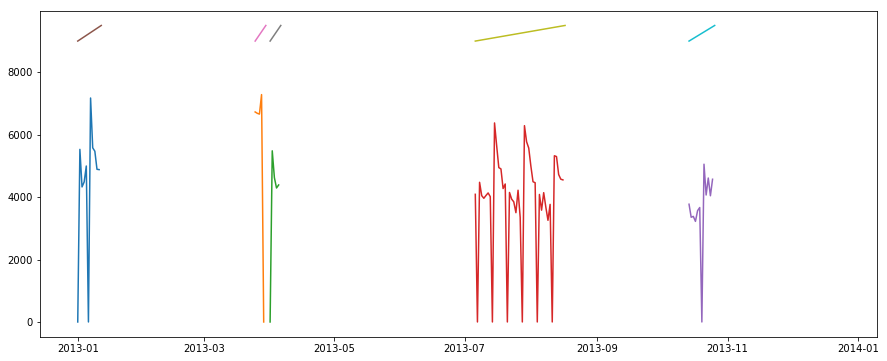

In [24]:
X=[]
Y=[]
X_=[]
Y_=[]
train_data_store1 = train_all[train_all.Store==1][::-1].reset_index()
train_data_store1 = train_data_store1[:360]
holiday_start = False
holiday_end = False
x_temp = []
y_temp = []
plt.figure(figsize=(15,6))
for i in range(len(train_data_store1)):
    d = train_data_store1.loc[i]
    if d.SchoolHoliday==1 and (i==0 or train_data_store1.loc[i-1].SchoolHoliday==0):
        X.append(d.Date)
        Y.append(9000)
        holiday_start = True
        holiday_end = False
        x_temp = []
        y_temp = []
    if d.SchoolHoliday==0 and (i==len(train_data_store1)-1 or train_data_store1.loc[i-1].SchoolHoliday==1):
        X.append(d.Date)
        Y.append(9500)
        holiday_end = True
        holiday_start = False
    if holiday_start and not holiday_end:
        x_temp.append(d.Date)
        y_temp.append(d.Sales)
    if holiday_end and not holiday_start:
        X_.append(x_temp)
        Y_.append(y_temp)
        holiday_end = False

for i in range(len(X_)):
    plt.plot(X_[i], Y_[i])
for i in range(0, min(len(X), len(Y)), 2):
    plt.plot(X[i:i+2], Y[i:i+2])
        

假期的销售额幅度不明显，看来假期对销售额的影响应该不大，至少不是主要的因素。

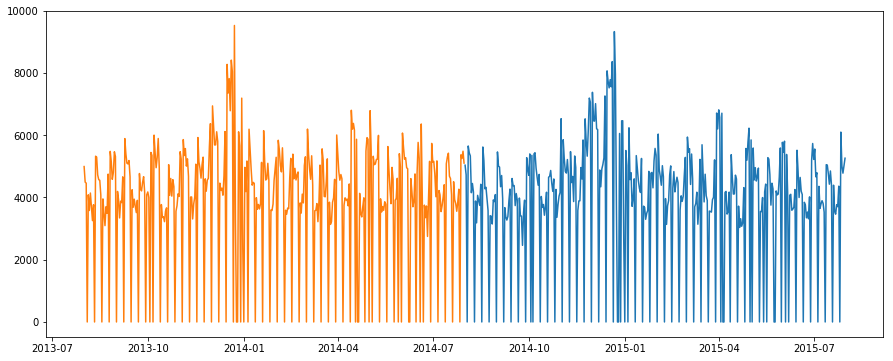

In [25]:
plt.figure(figsize=(15,6))
plt.plot(train_all[train_all.Store==1].Date[:365], train_all[train_all.Store==1].Sales[:365])
plt.plot(train_all[train_all.Store==1].Date[365:365+365], train_all[train_all.Store==1].Sales[365:365+365])

上述图很重要，分别表示了相邻的两年的销售额走势图，我们可以发现，大体上是一致的，这说明一个问题，销售额跟日期息息相关的，也就是说每一年的同一段时期内，可能销售额都会很接近，这就有点像很多行业有他的季节性特点的感觉，这一信息说明具体的日期对预测是至关重要的，因此我们需要提取出具体的年、月、日信息。

In [26]:
print '1~5平均销售额：'+str(train_data[train_data['DayOfWeek'] <=5].Sales.mean())
print '6平均销售额：'+str(train_data[train_data['DayOfWeek'] ==6].Sales.mean())
print '7平均销售额：'+str(train_data[train_data['DayOfWeek'] ==7].Sales.mean())

1~5平均销售额：6866.80635082
6平均销售额：5847.56259932
7平均销售额：204.183189387


可以看到相比于周六，周日对销售额的影响是巨大的，主要是因为很多商店这一天都关门吧(PS:关门的case是不计入最终得分的)。

分析一下每一天跟前一个星期、月、季度、半年、一年时间的平均销售额的对比。

train_all.sort_values(by=['Date'], inplace=True)
test_all.sort_values(by=['Date'], inplace=True)
test_all['Sales'] = [np.nan]*len(test_all)
roll_7s_train = pd.Series([])
roll_7s_test = pd.Series([])
roll_14s_train = pd.Series([])
roll_14s_test = pd.Series([])
roll_30s_train = pd.Series([])
roll_30s_test = pd.Series([])
roll_90s_train = pd.Series([])
roll_90s_test = pd.Series([])
roll_180s_train = pd.Series([])
roll_180s_test = pd.Series([])
roll_360s_train = pd.Series([])
roll_360s_test = pd.Series([])

for i in range(train_all.Store.min(), train_all.Store.max()+1, 1):
    sales_all = pd.concat([train_all[train_all['Store']==i][['Sales']], 
                           test_all[test_all['Store']==i][['Sales']]], ignore_index=True)['Sales']
    roll_7 = sales_all.ewm(span=7,min_periods=1, ignore_na=True).mean()
    roll_14 = sales_all.ewm(span=14,min_periods=1, ignore_na=True).mean()
    roll_30 = sales_all.ewm(span=30,min_periods=1, ignore_na=True).mean()
    roll_90 = sales_all.ewm(span=90,min_periods=1, ignore_na=True).mean()
    roll_180 = sales_all.ewm(span=180,min_periods=1, ignore_na=True).mean()
    roll_360 = sales_all.ewm(span=360,min_periods=1, ignore_na=True).mean()
    
    train_len = len(train_all[train_all['Store']==i])
    
    roll_7s_train = pd.concat([roll_7s_train, roll_7[:train_len]], ignore_index=True)
    roll_7s_test = pd.concat([roll_7s_test, roll_7[train_len:]], ignore_index=True)
    roll_14s_train = pd.concat([roll_14s_train, roll_14[:train_len]], ignore_index=True)
    roll_14s_test = pd.concat([roll_14s_test, roll_14[train_len:]], ignore_index=True)
    roll_30s_train = pd.concat([roll_30s_train, roll_30[:train_len]], ignore_index=True)
    roll_30s_test = pd.concat([roll_30s_test, roll_30[train_len:]], ignore_index=True)
    roll_90s_train = pd.concat([roll_90s_train, roll_90[:train_len]], ignore_index=True)
    roll_90s_test = pd.concat([roll_90s_test, roll_90[train_len:]], ignore_index=True)
    roll_180s_train = pd.concat([roll_180s_train, roll_180[:train_len]], ignore_index=True)
    roll_180s_test = pd.concat([roll_180s_test, roll_180[train_len:]], ignore_index=True)
    roll_360s_train = pd.concat([roll_360s_train, roll_360[:train_len]], ignore_index=True)
    roll_360s_test = pd.concat([roll_360s_test, roll_360[train_len:]], ignore_index=True)
    
train_all.sort_values(by=['Store'], inplace=True)
train_all.reset_index(inplace=True, drop=True)
train_all['Sales7']=roll_7s_train
train_all['Sales14']=roll_14s_train
train_all['Sales30']=roll_30s_train
train_all['Sales90']=roll_90s_train
train_all['Sales180']=roll_180s_train
train_all['Sales360']=roll_360s_train

test_all.sort_values(by=['Store'], inplace=True)
test_all.reset_index(inplace=True, drop=True)
test_all['Sales7']=roll_7s_test
test_all['Sales14']=roll_14s_test
test_all['Sales30']=roll_30s_test
test_all['Sales90']=roll_90s_test
test_all['Sales180']=roll_180s_test
test_all['Sales360']=roll_360s_test

train_all.sort_values(by=['Date'], inplace=True)
test_all.sort_values(by=['Date'], inplace=True)

plt.figure(figsize=(15,6))
X = range(len(train_all[train_all['Store']==555]))
plt.plot(X, train_all[train_all['Store']==555].Sales, label='every day')
plt.plot(X, train_all[train_all['Store']==555].Sales7, label='week')
plt.plot(X, train_all[train_all['Store']==555].Sales14, label='2week')
plt.plot(X, train_all[train_all['Store']==555].Sales30, label='month')
plt.plot(X, train_all[train_all['Store']==555].Sales90, label='season')
plt.plot(X, train_all[train_all['Store']==555].Sales180, label='halfyear')
plt.plot(X, train_all[train_all['Store']==555].Sales360, label='year')
plt.legend()
plt.show()

### 持续促销活动相关信息挖掘：PromoIntervel、Promo2SinceWeek、Promo2SinceYear

可以开发两个字段：
1. IsInPromo:分别表示当前店铺某天是否处于持续的促销活动中：根据Date、Promo2以及PromoIntervel。
2. PromoDays:促销活动已经持续的时间：根据Date以及Promo2SinceYear、Promo2SinceWeek。

In [27]:
def is_in_promo(data):
    '''
    data:DataFrame。
    return:返回bool值的Seris表示当前是否处于活动中。
    '''
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

In [28]:
def get_promo_months(data):
    '''
    return:返回活动已经持续的天数的Series。
    '''
    data['PromoOpen'] = 12*(data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek)/4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x>0 else 0)

### 竞争对手信息挖掘：CompetitionOpenSinceYear、CompetitionOpenSinceMonth

按照一般的理解上，竞争对手也应该对店铺的销售有很大影响，毕竟同一地区的市场份额是固定的，有一个距离比较近、开张比较久（老字号？）的竞争对手对销售额还是有压力的吧，分析以下。

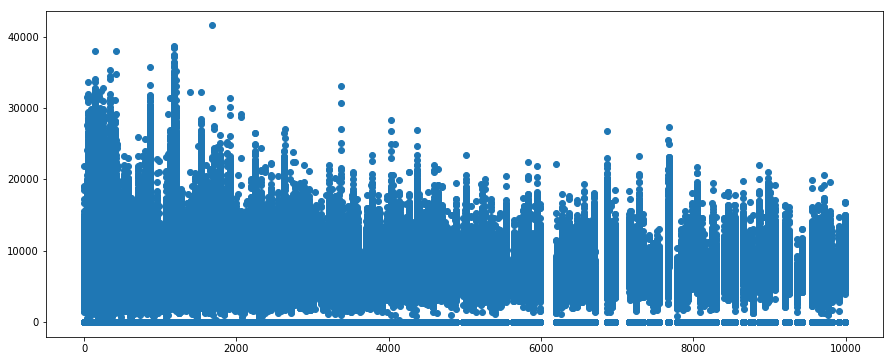

In [29]:
plt.figure(figsize=(15,6))
plt.scatter(train_all[train_all['CompetitionDistance']<10000].CompetitionDistance, train_all[train_all['CompetitionDistance']<10000].Sales)

可以看到一个奇怪的现象，似乎与我们的预计不符，并不是竞争对手越远，销售额越高，反而有点相反的意思，这个可能是类似商业圈的特点导致的吧，比如这一代有好几家同样的店，那么大家买这类商品时是不是都倾向于去这些地方买呢，那么就有一种互相促进的感觉，这一点是很有意思的点。

下面再看看跟竞争对手开张时间的关系。

增加字段：
1. CompetitionOpenMonths。

In [30]:
def get_competition_openmonths(data):
    '''
    return:返回截止当前竞争对手的开张时间，月为单位。
    '''
    data['CompetitionOpen'] = 12*(data.Year - data.CompetitionOpenSinceYear)+(data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x:x if x>0 else 0)

## 特征工程

### 挖掘到的新字段添加

#### Year、Month、Day、WeekOfYear、IsWorkDay

In [31]:
get_datetime_info(ho_train)
get_datetime_info(ho_test)
get_datetime_info(test_all)

#### 可视化

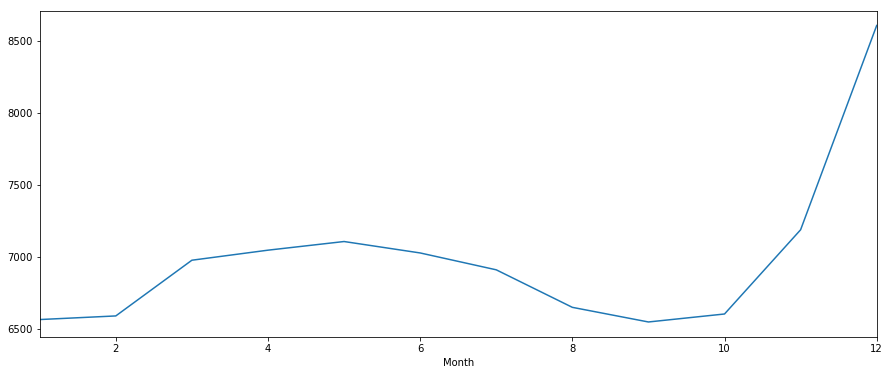

In [32]:
plt.figure(figsize=(15,6))
ho_train.groupby(['Month']).Sales.mean().plot()

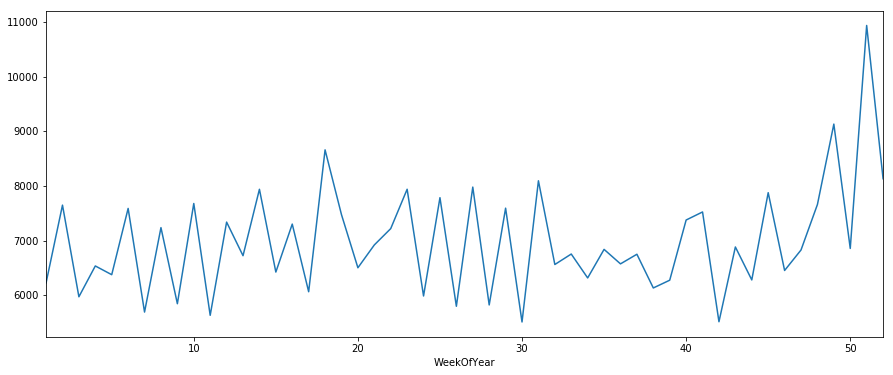

In [33]:
plt.figure(figsize=(15,6))
ho_train.groupby(['WeekOfYear']).Sales.mean().plot()

#### IsInPromo、PromoDays

In [34]:
is_in_promo(ho_train)
is_in_promo(ho_test)
is_in_promo(test_all)

In [35]:
get_promo_months(ho_train)
get_promo_months(ho_test)
get_promo_months(test_all)

#### 可视化

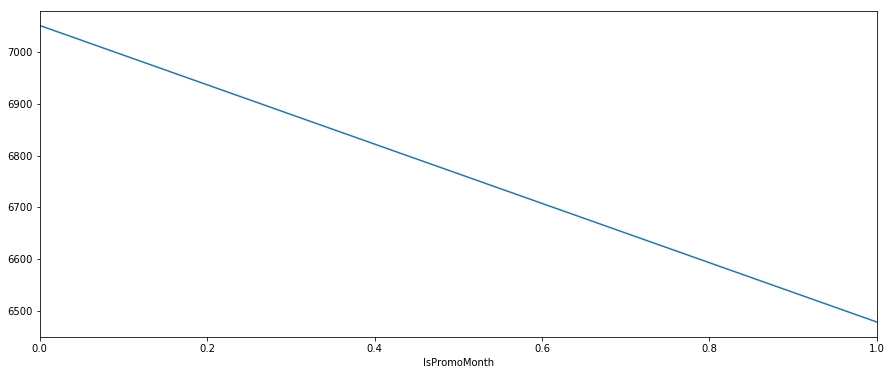

In [36]:
plt.figure(figsize=(15,6))
ho_train.groupby(['IsPromoMonth']).Sales.mean().plot()

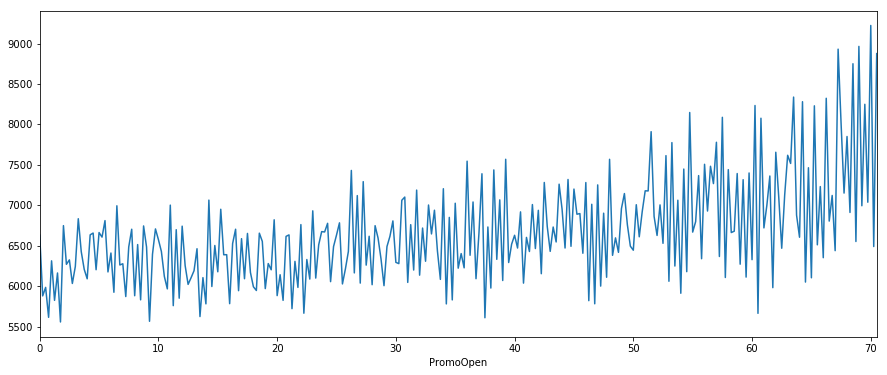

In [132]:
plt.figure(figsize=(15,6))
ho_train[ho_train.PromoOpen<1000].groupby(['PromoOpen']).Sales.mean().plot()

In [39]:
ho_train.head()[['Year','Promo2SinceYear','WeekOfYear','Promo2SinceWeek','PromoOpen']]

,Year,Promo2SinceYear,WeekOfYear,Promo2SinceWeek,PromoOpen
284584,2015,2013.0,25,31.0,22.50
417104,2015,0.0,25,0.0,24186.25
875290,2015,0.0,25,0.0,24186.25
119580,2015,2012.0,25,27.0,35.50
807974,2015,2009.0,25,37.0,69.00


上述表示，促销对销售额的影响是非常明显的，但是持续时间同样存在着影响。注意一点，有的店的Promo2SinceYear为0，导致PromoOpen计算出来很大。

#### CompetitionOpenMonths

In [40]:
get_competition_openmonths(ho_train)
get_competition_openmonths(ho_test)
get_competition_openmonths(test_all)

### 无用字段丢弃，注意test.csv是没有Customers数据的哈

Date、Customers、Open、PromoInterval、monthStr

In [41]:
ho_train.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)
ho_test.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)

### 当前字段

In [42]:
ho_train.columns

Index([u'Store', u'DayOfWeek', u'Sales', u'Promo', u'StateHoliday',
       u'SchoolHoliday', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'Year', u'Month', u'Day',
       u'WeekOfYear', u'IsPromoMonth', u'PromoOpen', u'CompetitionOpen'],
      dtype='object')

### 枚举字段One-Hot编码

当前的枚举字段有：
1. StateHoliday:国家假日，一般假日国家假期都会关门，所有学校在公共假日都会关门，a=公共假日，b=东部假日，c=圣诞节，0=不是假日。
2. StoreType:商店类型，有四种，abcd。
3. Assortment:分类级别，a=基础，b=额外，c=扩展。

在模型中应该是类似节点一样的存在，即作为四个节点将数据导向四个方向，因此将a、b、c、d都映射到1,2,3,4上，不使用OneHot编码，毕竟编码后的维度会增加。

train_all.head(3)
train_all = pd.get_dummies(train_all, columns=['StateHoliday', 'StoreType', 'Assortment'])
train_all.info()
test_all = pd.get_dummies(test_all, columns=['StateHoliday', 'StoreType', 'Assortment'])
test_all.info()

In [43]:
def one_hot(data):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

In [44]:
one_hot(ho_train)
one_hot(ho_test)
one_hot(test_all)

## 数值型数据归一化处理

这主要是避免由数值大小导致的字段在对预测结果的影响中权重不一致，因此做归一化处理，即认为每个字段的影响都是一样的。

数值型字段有：
1. Sales：预测值不用管。
2. CompetitionDistance。
3. PromoDays。
4. CompetitionOpenMonths。

但是有个问题，如果对训练数据、测试数据分别进行了归一化，因为归一化使用的min、max不同，是否对预测有影响不可而知，暂时不进行归一化处理。

### 做归一化之前，我们要先查看下数据中是否有异常值，比如极大极小值等，避免对归一化结果造成影响

plt.figure(figsize=(15,15))
plt.plot(train_all.CompetitionDistance)

print 'min:'+str(train_all.CompetitionDistance.min())

print 'max:'+str(train_all.CompetitionDistance.max())

恩恩，也没啥问题，不过这个min为20，这个不会是楼上楼下的关系吧，真的不会打起来么。。。。

### 进行归一化

归一化就使用简单的min-max归一化（是否需要看下数值的分布再决定呢，不是有个归一化算法可以减少值间距导致的差异么），因为现在所有字段都可以理解为数值型，因此直接应用到整个DataFrame上也是可以的，不过为了速度就不这么做了。

train_all.CompetitionDistance = ((train_all.CompetitionDistance - train_all.CompetitionDistance.min())/(train_all.CompetitionDistance.max() - train_all.CompetitionDistance.min()))
test_all.CompetitionDistance = ((test_all.CompetitionDistance - test_all.CompetitionDistance.min())/(test_all.CompetitionDistance.max() - test_all.CompetitionDistance.min()))
print 'min:'+str(train_all.CompetitionDistance.min())
print 'max:'+str(train_all.CompetitionDistance.max())
print 'mean:'+str(train_all.CompetitionDistance.mean())

## 提取目标字段

In [47]:
ho_xtrain = ho_train.drop(['Sales'],axis=1 )
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

## 基准模型

基准模型采用恒定猜测为mean值的方式。

先将训练集中Sales的mean值计算出来。

In [48]:
pred_base = np.expm1(ho_ytrain).mean()
print '基准模型预测值：'+str(pred_base)

基准模型预测值：6954.82295387


## 性能指标

由于是要提交到kaggle，因此我们选择和kaggle一致的性能指标，即RMSPE。

In [49]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

跟RMSE不同的是引入了/y_i的处理，这样就不会忽略销量很低的情况了。

## 计算基准模型的性能

In [50]:
print '基准模型的RMSPE：'+str(rmspe([pred_base]*len(ho_ytest), np.expm1(ho_ytest)))

基准模型的RMSPE：0.439230133834


可以看到是一个很高的误差率了，就是不知道跟我们的模型比较如何。

## 主流程

接下来就是我们的模型相关的流程，之前的数据处理、基准模型构建、基准阈值计算、性能指标函数构建已经完成了，后续主要就是PCA以及模型构建、比较、调试的迭代过程了。

模型选择：本来是选择Adaboost，看中它在小数据集上的表现，但是开题报告的审阅导师推荐了xGBoost，去了解了一下，发现如何区别：
1. adaboost：在优化弱分类器时，依赖的是权重的设置，即加大分类错误的数据的权重，而减小分类正确的数据的权重，使得后续的分类器更关注之前分类错误的点。
2. GBDT：相比较adaboost，区别在于它是通过算梯度来定位模型的不足，因此相比较AdaBoost，它能使用更多的目标函数，比如我们的性能指标函数RMSPE。

而XGBoost是在GBDT的基础上的全方位加强版，具体表现在支持线性分类器、加入了正则项控制模型复杂度、学习速率、速度更快，支持并行等，因此我们的模型优先选择**XGBoost**。

### PCA

进行PCA的目的：
1. 去除数据噪音。
2. 降维，我们的维度高达1000+，以当前数据是不可能描述这么多维度的。
3. 更加了解数据，很多字段我们根本不知道跟目标的关系是什么，pca可以帮助我们梳理这一关系。

第一版的时候由于维度非常多，因此我采用了PCA，主要用于降维，以及特征提取，第二版由于去掉了大部分OneHot部分，因此维度并不是很高，先去掉PCA，毕竟PCA对信息是有损失的。

    from sklearn.decomposition import PCA

    pca = PCA(n_components=10).fit(x_train)
    print pca.explained_variance_ratio_
    print sum(pca.explained_variance_ratio_)

可以看到，效果并不是很理想，前10个新特征总共表现了原来50%的变化，不过也比原来好了很多，先用这个看看。

    x_train_pca = pd.DataFrame(pca.transform(x_train))
    x_valid_pca = pd.DataFrame(pca.transform(x_valid))
    x_train_pca.info()

### 模型构建

导入库、训练数据处理

In [51]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

train_matrix = xgb.DMatrix(x_train, y_train)
valid_matrix = xgb.DMatrix(x_valid, y_valid)
watchlist = [(train_matrix, 'train'), (valid_matrix, 'valid')]

### 模型训练

#### 模型训练

xgboost基本调参方式：
1. 选择一个较大的学习率，一般在0.05到0.3，然后设置一个该学习率对应下合适的n_estimators。
2. 调参max_depth、min_child_weight，这两个参数对结果影响很大。
3. 调参subsample、colsample_bytree。
4. 调参gamma。
5. 降低learning_rate，再匹配一个合适的n_estimators。

In [58]:
train_matrix = xgb.DMatrix(ho_xtrain, ho_ytrain)
valid_matrix = xgb.DMatrix(ho_xtest, ho_ytest)
watchlist = [(train_matrix, 'train'), (valid_matrix, 'valid')]

In [59]:
params_opt = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 66
          }
num_boost_round_opt = 6000

In [60]:
def train(params, num_boost_round):
    print 'XGBoost Model Train Start....'
    start_time = time.time()
    model = xgb.train(params, train_matrix, num_boost_round, evals=watchlist, 
                      early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
    print 'XGBoost Model Train End, Time: {:4f} s....'.format(time.time()-start_time)
    return model

In [61]:
model_opt = train(params_opt, num_boost_round_opt)

XGBoost Model Train Start....
[0]	train-rmse:8.02075	valid-rmse:8.0279	train-rmspe:0.999809	valid-rmspe:0.999811
Multiple eval metrics have been passed: 'valid-rmspe' will be used for early stopping.

Will train until valid-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78068	valid-rmse:7.78703	train-rmspe:0.999711	valid-rmspe:0.999714
[2]	train-rmse:7.54777	valid-rmse:7.55404	train-rmspe:0.99959	valid-rmspe:0.999595
[3]	train-rmse:7.32188	valid-rmse:7.3285	train-rmspe:0.999443	valid-rmspe:0.99945
[4]	train-rmse:7.1027	valid-rmse:7.1097	train-rmspe:0.999266	valid-rmspe:0.999275
[5]	train-rmse:6.89012	valid-rmse:6.89766	train-rmspe:0.999054	valid-rmspe:0.999065
[6]	train-rmse:6.68397	valid-rmse:6.69152	train-rmspe:0.998799	valid-rmspe:0.998814
[7]	train-rmse:6.48402	valid-rmse:6.49139	train-rmspe:0.998498	valid-rmspe:0.998516
[8]	train-rmse:6.29006	valid-rmse:6.29802	train-rmspe:0.998141	valid-rmspe:0.998165
[9]	train-rmse:6.10193	valid-rmse:6.10985	train-rmspe:0.997724	valid-rms

[95]	train-rmse:0.511749	valid-rmse:0.503335	train-rmspe:0.391844	valid-rmspe:0.374745
[96]	train-rmse:0.499706	valid-rmse:0.491349	train-rmspe:0.385473	valid-rmspe:0.367806
[97]	train-rmse:0.488439	valid-rmse:0.48006	train-rmspe:0.379393	valid-rmspe:0.361159
[98]	train-rmse:0.477604	valid-rmse:0.469355	train-rmspe:0.373517	valid-rmspe:0.354831
[99]	train-rmse:0.467101	valid-rmse:0.45908	train-rmspe:0.367829	valid-rmspe:0.348741
[100]	train-rmse:0.456734	valid-rmse:0.448776	train-rmspe:0.362271	valid-rmspe:0.342677
[101]	train-rmse:0.446831	valid-rmse:0.439175	train-rmspe:0.356962	valid-rmspe:0.336974
[102]	train-rmse:0.437295	valid-rmse:0.429815	train-rmspe:0.351808	valid-rmspe:0.331419
[103]	train-rmse:0.428345	valid-rmse:0.421035	train-rmspe:0.346973	valid-rmspe:0.326193
[104]	train-rmse:0.419561	valid-rmse:0.412515	train-rmspe:0.34229	valid-rmspe:0.321143
[105]	train-rmse:0.411081	valid-rmse:0.404316	train-rmspe:0.337741	valid-rmspe:0.316272
[106]	train-rmse:0.402731	valid-rmse:0.3

[189]	train-rmse:0.202159	valid-rmse:0.211127	train-rmspe:0.248715	valid-rmspe:0.222567
[190]	train-rmse:0.201771	valid-rmse:0.210788	train-rmspe:0.248533	valid-rmspe:0.222429
[191]	train-rmse:0.201113	valid-rmse:0.210239	train-rmspe:0.248165	valid-rmspe:0.221992
[192]	train-rmse:0.20043	valid-rmse:0.209705	train-rmspe:0.24762	valid-rmspe:0.221544
[193]	train-rmse:0.199715	valid-rmse:0.209115	train-rmspe:0.247207	valid-rmspe:0.221151
[194]	train-rmse:0.198626	valid-rmse:0.208254	train-rmspe:0.246422	valid-rmspe:0.220427
[195]	train-rmse:0.197789	valid-rmse:0.207523	train-rmspe:0.245763	valid-rmspe:0.219753
[196]	train-rmse:0.197606	valid-rmse:0.207369	train-rmspe:0.245841	valid-rmspe:0.219806
[197]	train-rmse:0.197085	valid-rmse:0.206931	train-rmspe:0.245508	valid-rmspe:0.219515
[198]	train-rmse:0.196798	valid-rmse:0.20667	train-rmspe:0.245445	valid-rmspe:0.219407
[199]	train-rmse:0.196618	valid-rmse:0.206559	train-rmspe:0.245433	valid-rmspe:0.219491
[200]	train-rmse:0.195918	valid-rms

[283]	train-rmse:0.1583	valid-rmse:0.172925	train-rmspe:0.204645	valid-rmspe:0.187941
[284]	train-rmse:0.157837	valid-rmse:0.172518	train-rmspe:0.204108	valid-rmspe:0.187446
[285]	train-rmse:0.157601	valid-rmse:0.172303	train-rmspe:0.203666	valid-rmspe:0.187221
[286]	train-rmse:0.157518	valid-rmse:0.172176	train-rmspe:0.20358	valid-rmspe:0.187099
[287]	train-rmse:0.156897	valid-rmse:0.171625	train-rmspe:0.203066	valid-rmspe:0.186524
[288]	train-rmse:0.156434	valid-rmse:0.171223	train-rmspe:0.201479	valid-rmspe:0.186078
[289]	train-rmse:0.156297	valid-rmse:0.171131	train-rmspe:0.20138	valid-rmspe:0.186001
[290]	train-rmse:0.156114	valid-rmse:0.170972	train-rmspe:0.201209	valid-rmspe:0.185837
[291]	train-rmse:0.155859	valid-rmse:0.170736	train-rmspe:0.200989	valid-rmspe:0.185577
[292]	train-rmse:0.15572	valid-rmse:0.17067	train-rmspe:0.200869	valid-rmspe:0.18552
[293]	train-rmse:0.155529	valid-rmse:0.170543	train-rmspe:0.198731	valid-rmspe:0.185392
[294]	train-rmse:0.155294	valid-rmse:0.

[377]	train-rmse:0.134922	valid-rmse:0.152678	train-rmspe:0.165965	valid-rmspe:0.165763
[378]	train-rmse:0.134815	valid-rmse:0.152585	train-rmspe:0.165853	valid-rmspe:0.165688
[379]	train-rmse:0.134684	valid-rmse:0.152473	train-rmspe:0.165639	valid-rmspe:0.165573
[380]	train-rmse:0.134598	valid-rmse:0.152396	train-rmspe:0.165264	valid-rmspe:0.165501
[381]	train-rmse:0.134546	valid-rmse:0.152356	train-rmspe:0.165121	valid-rmspe:0.165453
[382]	train-rmse:0.134392	valid-rmse:0.152247	train-rmspe:0.164921	valid-rmspe:0.165342
[383]	train-rmse:0.134278	valid-rmse:0.152157	train-rmspe:0.164803	valid-rmspe:0.165254
[384]	train-rmse:0.13402	valid-rmse:0.151972	train-rmspe:0.164527	valid-rmspe:0.16504
[385]	train-rmse:0.133938	valid-rmse:0.1519	train-rmspe:0.164395	valid-rmspe:0.164969
[386]	train-rmse:0.133888	valid-rmse:0.151866	train-rmspe:0.163646	valid-rmspe:0.164927
[387]	train-rmse:0.133613	valid-rmse:0.151664	train-rmspe:0.16339	valid-rmspe:0.164711
[388]	train-rmse:0.133468	valid-rmse:

[471]	train-rmse:0.12167	valid-rmse:0.142019	train-rmspe:0.146637	valid-rmspe:0.154034
[472]	train-rmse:0.121617	valid-rmse:0.141972	train-rmspe:0.146583	valid-rmspe:0.153985
[473]	train-rmse:0.121562	valid-rmse:0.142033	train-rmspe:0.146458	valid-rmspe:0.15409
[474]	train-rmse:0.121477	valid-rmse:0.141974	train-rmspe:0.146365	valid-rmspe:0.154034
[475]	train-rmse:0.121304	valid-rmse:0.141828	train-rmspe:0.146194	valid-rmspe:0.153877
[476]	train-rmse:0.121232	valid-rmse:0.141904	train-rmspe:0.146118	valid-rmspe:0.153997
[477]	train-rmse:0.121106	valid-rmse:0.141773	train-rmspe:0.145987	valid-rmspe:0.153847
[478]	train-rmse:0.120926	valid-rmse:0.141579	train-rmspe:0.145818	valid-rmspe:0.153617
[479]	train-rmse:0.120839	valid-rmse:0.141605	train-rmspe:0.145723	valid-rmspe:0.153653
[480]	train-rmse:0.120762	valid-rmse:0.141556	train-rmspe:0.145652	valid-rmspe:0.153599
[481]	train-rmse:0.120687	valid-rmse:0.141496	train-rmspe:0.145577	valid-rmspe:0.153531
[482]	train-rmse:0.120616	valid-rm

[565]	train-rmse:0.11194	valid-rmse:0.134967	train-rmspe:0.134537	valid-rmspe:0.146324
[566]	train-rmse:0.111866	valid-rmse:0.134911	train-rmspe:0.134461	valid-rmspe:0.146258
[567]	train-rmse:0.111722	valid-rmse:0.134794	train-rmspe:0.134308	valid-rmspe:0.146127
[568]	train-rmse:0.111703	valid-rmse:0.134782	train-rmspe:0.134028	valid-rmspe:0.146114
[569]	train-rmse:0.111577	valid-rmse:0.134691	train-rmspe:0.133903	valid-rmspe:0.146012
[570]	train-rmse:0.111481	valid-rmse:0.13464	train-rmspe:0.133813	valid-rmspe:0.145959
[571]	train-rmse:0.111417	valid-rmse:0.134595	train-rmspe:0.133752	valid-rmspe:0.145896
[572]	train-rmse:0.111342	valid-rmse:0.134611	train-rmspe:0.133659	valid-rmspe:0.145941
[573]	train-rmse:0.111221	valid-rmse:0.134518	train-rmspe:0.13354	valid-rmspe:0.145835
[574]	train-rmse:0.111194	valid-rmse:0.134494	train-rmspe:0.133323	valid-rmspe:0.145815
[575]	train-rmse:0.111047	valid-rmse:0.134392	train-rmspe:0.133159	valid-rmspe:0.145699
[576]	train-rmse:0.110913	valid-rms

[659]	train-rmse:0.105179	valid-rmse:0.130139	train-rmspe:0.126766	valid-rmspe:0.140879
[660]	train-rmse:0.105118	valid-rmse:0.130113	train-rmspe:0.126637	valid-rmspe:0.140858
[661]	train-rmse:0.105099	valid-rmse:0.130105	train-rmspe:0.126618	valid-rmspe:0.140847
[662]	train-rmse:0.105032	valid-rmse:0.13006	train-rmspe:0.126537	valid-rmspe:0.140796
[663]	train-rmse:0.104903	valid-rmse:0.129963	train-rmspe:0.12641	valid-rmspe:0.140689
[664]	train-rmse:0.104794	valid-rmse:0.12991	train-rmspe:0.126308	valid-rmspe:0.140628
[665]	train-rmse:0.104727	valid-rmse:0.129903	train-rmspe:0.126245	valid-rmspe:0.140621
[666]	train-rmse:0.10453	valid-rmse:0.12976	train-rmspe:0.126052	valid-rmspe:0.14046
[667]	train-rmse:0.104488	valid-rmse:0.129739	train-rmspe:0.126017	valid-rmspe:0.140438
[668]	train-rmse:0.104435	valid-rmse:0.129699	train-rmspe:0.125966	valid-rmspe:0.140391
[669]	train-rmse:0.104378	valid-rmse:0.129654	train-rmspe:0.12589	valid-rmspe:0.140337
[670]	train-rmse:0.104331	valid-rmse:0.

[753]	train-rmse:0.099886	valid-rmse:0.126864	train-rmspe:0.120142	valid-rmspe:0.137313
[754]	train-rmse:0.09978	valid-rmse:0.126796	train-rmspe:0.120045	valid-rmspe:0.137233
[755]	train-rmse:0.099743	valid-rmse:0.126799	train-rmspe:0.120007	valid-rmspe:0.137239
[756]	train-rmse:0.099719	valid-rmse:0.126785	train-rmspe:0.119986	valid-rmspe:0.137224
[757]	train-rmse:0.099618	valid-rmse:0.126723	train-rmspe:0.119633	valid-rmspe:0.137158
[758]	train-rmse:0.09959	valid-rmse:0.12672	train-rmspe:0.119589	valid-rmspe:0.137162
[759]	train-rmse:0.099551	valid-rmse:0.126712	train-rmspe:0.119553	valid-rmspe:0.137156
[760]	train-rmse:0.099486	valid-rmse:0.126657	train-rmspe:0.119453	valid-rmspe:0.137096
[761]	train-rmse:0.099463	valid-rmse:0.126649	train-rmspe:0.119096	valid-rmspe:0.13709
[762]	train-rmse:0.099446	valid-rmse:0.126639	train-rmspe:0.119056	valid-rmspe:0.137078
[763]	train-rmse:0.099349	valid-rmse:0.126573	train-rmspe:0.118972	valid-rmspe:0.137003
[764]	train-rmse:0.099312	valid-rmse

[847]	train-rmse:0.095808	valid-rmse:0.124448	train-rmspe:0.113258	valid-rmspe:0.134642
[848]	train-rmse:0.09575	valid-rmse:0.124407	train-rmspe:0.113201	valid-rmspe:0.134589
[849]	train-rmse:0.095726	valid-rmse:0.124398	train-rmspe:0.113171	valid-rmspe:0.13458
[850]	train-rmse:0.095685	valid-rmse:0.124332	train-rmspe:0.113125	valid-rmspe:0.134491
[851]	train-rmse:0.095675	valid-rmse:0.124328	train-rmspe:0.113118	valid-rmspe:0.134488
[852]	train-rmse:0.095661	valid-rmse:0.124316	train-rmspe:0.113082	valid-rmspe:0.134477
[853]	train-rmse:0.09563	valid-rmse:0.124304	train-rmspe:0.113051	valid-rmspe:0.134465
[854]	train-rmse:0.095592	valid-rmse:0.124291	train-rmspe:0.113005	valid-rmspe:0.134448
[855]	train-rmse:0.095572	valid-rmse:0.124273	train-rmspe:0.112983	valid-rmspe:0.134427
[856]	train-rmse:0.095539	valid-rmse:0.12426	train-rmspe:0.112948	valid-rmspe:0.134413
[857]	train-rmse:0.095516	valid-rmse:0.124251	train-rmspe:0.112925	valid-rmspe:0.134402
[858]	train-rmse:0.095467	valid-rmse

[941]	train-rmse:0.092773	valid-rmse:0.122755	train-rmspe:0.109189	valid-rmspe:0.132734
[942]	train-rmse:0.09275	valid-rmse:0.122756	train-rmspe:0.109166	valid-rmspe:0.132738
[943]	train-rmse:0.092715	valid-rmse:0.122779	train-rmspe:0.109089	valid-rmspe:0.132753
[944]	train-rmse:0.092673	valid-rmse:0.122758	train-rmspe:0.109042	valid-rmspe:0.132726
[945]	train-rmse:0.092648	valid-rmse:0.122751	train-rmspe:0.109015	valid-rmspe:0.132724
[946]	train-rmse:0.092619	valid-rmse:0.122741	train-rmspe:0.108983	valid-rmspe:0.132712
[947]	train-rmse:0.092548	valid-rmse:0.122691	train-rmspe:0.108911	valid-rmspe:0.132655
[948]	train-rmse:0.092479	valid-rmse:0.122645	train-rmspe:0.108792	valid-rmspe:0.132602
[949]	train-rmse:0.09246	valid-rmse:0.122634	train-rmspe:0.108775	valid-rmspe:0.13259
[950]	train-rmse:0.092439	valid-rmse:0.122628	train-rmspe:0.108753	valid-rmspe:0.132582
[951]	train-rmse:0.092386	valid-rmse:0.122594	train-rmspe:0.108699	valid-rmspe:0.132546
[952]	train-rmse:0.092339	valid-rms

[1035]	train-rmse:0.089989	valid-rmse:0.121896	train-rmspe:0.104888	valid-rmspe:0.13188
[1036]	train-rmse:0.089964	valid-rmse:0.121895	train-rmspe:0.104862	valid-rmspe:0.131876
[1037]	train-rmse:0.089943	valid-rmse:0.121887	train-rmspe:0.104835	valid-rmspe:0.131867
[1038]	train-rmse:0.089928	valid-rmse:0.12188	train-rmspe:0.104817	valid-rmspe:0.13186
[1039]	train-rmse:0.089914	valid-rmse:0.121876	train-rmspe:0.104819	valid-rmspe:0.131855
[1040]	train-rmse:0.089871	valid-rmse:0.121868	train-rmspe:0.104775	valid-rmspe:0.131853
[1041]	train-rmse:0.089841	valid-rmse:0.121849	train-rmspe:0.104748	valid-rmspe:0.131832
[1042]	train-rmse:0.089815	valid-rmse:0.121836	train-rmspe:0.104708	valid-rmspe:0.131821
[1043]	train-rmse:0.089793	valid-rmse:0.121823	train-rmspe:0.104676	valid-rmspe:0.131801
[1044]	train-rmse:0.089772	valid-rmse:0.121808	train-rmspe:0.104653	valid-rmspe:0.131785
[1045]	train-rmse:0.089742	valid-rmse:0.121795	train-rmspe:0.104623	valid-rmspe:0.131769
[1046]	train-rmse:0.0897

[1128]	train-rmse:0.087796	valid-rmse:0.121133	train-rmspe:0.101909	valid-rmspe:0.131091
[1129]	train-rmse:0.087776	valid-rmse:0.121127	train-rmspe:0.101889	valid-rmspe:0.131085
[1130]	train-rmse:0.087745	valid-rmse:0.121113	train-rmspe:0.101841	valid-rmspe:0.131072
[1131]	train-rmse:0.087708	valid-rmse:0.121096	train-rmspe:0.101805	valid-rmspe:0.131053
[1132]	train-rmse:0.087686	valid-rmse:0.121088	train-rmspe:0.101783	valid-rmspe:0.131043
[1133]	train-rmse:0.087648	valid-rmse:0.121064	train-rmspe:0.101746	valid-rmspe:0.131019
[1134]	train-rmse:0.087625	valid-rmse:0.121059	train-rmspe:0.101725	valid-rmspe:0.131017
[1135]	train-rmse:0.087613	valid-rmse:0.121056	train-rmspe:0.101695	valid-rmspe:0.131012
[1136]	train-rmse:0.0876	valid-rmse:0.121055	train-rmspe:0.101681	valid-rmspe:0.131012
[1137]	train-rmse:0.087579	valid-rmse:0.121052	train-rmspe:0.101649	valid-rmspe:0.13101
[1138]	train-rmse:0.08757	valid-rmse:0.121033	train-rmspe:0.101636	valid-rmspe:0.130981
[1139]	train-rmse:0.08755

[1221]	train-rmse:0.085905	valid-rmse:0.120515	train-rmspe:0.099021	valid-rmspe:0.130492
[1222]	train-rmse:0.085879	valid-rmse:0.120504	train-rmspe:0.098988	valid-rmspe:0.130481
[1223]	train-rmse:0.085852	valid-rmse:0.120494	train-rmspe:0.098949	valid-rmspe:0.13047
[1224]	train-rmse:0.085834	valid-rmse:0.120489	train-rmspe:0.098927	valid-rmspe:0.130465
[1225]	train-rmse:0.085797	valid-rmse:0.120471	train-rmspe:0.09889	valid-rmspe:0.130447
[1226]	train-rmse:0.085781	valid-rmse:0.120461	train-rmspe:0.098874	valid-rmspe:0.130436
[1227]	train-rmse:0.085749	valid-rmse:0.120464	train-rmspe:0.098842	valid-rmspe:0.130438
[1228]	train-rmse:0.085731	valid-rmse:0.120456	train-rmspe:0.098824	valid-rmspe:0.130429
[1229]	train-rmse:0.085689	valid-rmse:0.120424	train-rmspe:0.09878	valid-rmspe:0.130392
[1230]	train-rmse:0.085673	valid-rmse:0.120422	train-rmspe:0.098755	valid-rmspe:0.130389
[1231]	train-rmse:0.085642	valid-rmse:0.120434	train-rmspe:0.098682	valid-rmspe:0.13041
[1232]	train-rmse:0.08562

[1314]	train-rmse:0.084075	valid-rmse:0.119801	train-rmspe:0.095864	valid-rmspe:0.12969
[1315]	train-rmse:0.084055	valid-rmse:0.119787	train-rmspe:0.095828	valid-rmspe:0.129678
[1316]	train-rmse:0.084034	valid-rmse:0.119802	train-rmspe:0.095664	valid-rmspe:0.129701
[1317]	train-rmse:0.08402	valid-rmse:0.119799	train-rmspe:0.095586	valid-rmspe:0.129698
[1318]	train-rmse:0.084004	valid-rmse:0.119795	train-rmspe:0.095569	valid-rmspe:0.129693
[1319]	train-rmse:0.083974	valid-rmse:0.119784	train-rmspe:0.09552	valid-rmspe:0.129681
[1320]	train-rmse:0.083963	valid-rmse:0.119788	train-rmspe:0.095507	valid-rmspe:0.12969
[1321]	train-rmse:0.083952	valid-rmse:0.119786	train-rmspe:0.095497	valid-rmspe:0.12969
[1322]	train-rmse:0.083944	valid-rmse:0.119782	train-rmspe:0.09549	valid-rmspe:0.129687
[1323]	train-rmse:0.083931	valid-rmse:0.119776	train-rmspe:0.095467	valid-rmspe:0.129681
[1324]	train-rmse:0.083921	valid-rmse:0.119775	train-rmspe:0.095454	valid-rmspe:0.129678
[1325]	train-rmse:0.083899	

[1407]	train-rmse:0.082421	valid-rmse:0.119252	train-rmspe:0.092906	valid-rmspe:0.129144
[1408]	train-rmse:0.082408	valid-rmse:0.119251	train-rmspe:0.092889	valid-rmspe:0.129135
[1409]	train-rmse:0.082398	valid-rmse:0.11925	train-rmspe:0.09288	valid-rmspe:0.129134
[1410]	train-rmse:0.082371	valid-rmse:0.119242	train-rmspe:0.092839	valid-rmspe:0.129128
[1411]	train-rmse:0.082353	valid-rmse:0.119234	train-rmspe:0.09282	valid-rmspe:0.12912
[1412]	train-rmse:0.082339	valid-rmse:0.119224	train-rmspe:0.092805	valid-rmspe:0.12911
[1413]	train-rmse:0.082322	valid-rmse:0.119226	train-rmspe:0.092782	valid-rmspe:0.129111
[1414]	train-rmse:0.082308	valid-rmse:0.119256	train-rmspe:0.092769	valid-rmspe:0.129143
[1415]	train-rmse:0.082297	valid-rmse:0.119254	train-rmspe:0.092756	valid-rmspe:0.129141
[1416]	train-rmse:0.082282	valid-rmse:0.119221	train-rmspe:0.09274	valid-rmspe:0.129096
[1417]	train-rmse:0.082257	valid-rmse:0.119248	train-rmspe:0.092711	valid-rmspe:0.12913
[1418]	train-rmse:0.082231	v

[1500]	train-rmse:0.080927	valid-rmse:0.118847	train-rmspe:0.090841	valid-rmspe:0.128707
[1501]	train-rmse:0.080905	valid-rmse:0.118841	train-rmspe:0.090818	valid-rmspe:0.128699
[1502]	train-rmse:0.080884	valid-rmse:0.118831	train-rmspe:0.090796	valid-rmspe:0.128686
[1503]	train-rmse:0.080867	valid-rmse:0.118865	train-rmspe:0.09077	valid-rmspe:0.128733
[1504]	train-rmse:0.080858	valid-rmse:0.118852	train-rmspe:0.090761	valid-rmspe:0.128713
[1505]	train-rmse:0.080843	valid-rmse:0.118844	train-rmspe:0.090747	valid-rmspe:0.128706
[1506]	train-rmse:0.080827	valid-rmse:0.118826	train-rmspe:0.090721	valid-rmspe:0.128677
[1507]	train-rmse:0.080808	valid-rmse:0.11882	train-rmspe:0.090698	valid-rmspe:0.128674
[1508]	train-rmse:0.080794	valid-rmse:0.118812	train-rmspe:0.090685	valid-rmspe:0.128666
[1509]	train-rmse:0.080782	valid-rmse:0.118809	train-rmspe:0.090672	valid-rmspe:0.12866
[1510]	train-rmse:0.080773	valid-rmse:0.118809	train-rmspe:0.090664	valid-rmspe:0.128658
[1511]	train-rmse:0.0807

[1593]	train-rmse:0.079678	valid-rmse:0.118593	train-rmspe:0.089097	valid-rmspe:0.128396
[1594]	train-rmse:0.079671	valid-rmse:0.118591	train-rmspe:0.089088	valid-rmspe:0.128394
[1595]	train-rmse:0.079663	valid-rmse:0.118583	train-rmspe:0.08908	valid-rmspe:0.128388
[1596]	train-rmse:0.079647	valid-rmse:0.118582	train-rmspe:0.089065	valid-rmspe:0.128386
[1597]	train-rmse:0.079636	valid-rmse:0.118581	train-rmspe:0.089044	valid-rmspe:0.128384
[1598]	train-rmse:0.079624	valid-rmse:0.11858	train-rmspe:0.089031	valid-rmspe:0.128383
[1599]	train-rmse:0.079609	valid-rmse:0.118586	train-rmspe:0.088981	valid-rmspe:0.128398
[1600]	train-rmse:0.079596	valid-rmse:0.118583	train-rmspe:0.088967	valid-rmspe:0.128395
[1601]	train-rmse:0.079577	valid-rmse:0.118566	train-rmspe:0.088949	valid-rmspe:0.128372
[1602]	train-rmse:0.079562	valid-rmse:0.118565	train-rmspe:0.088869	valid-rmspe:0.128371
[1603]	train-rmse:0.079551	valid-rmse:0.118568	train-rmspe:0.088856	valid-rmspe:0.128372
[1604]	train-rmse:0.079

[1686]	train-rmse:0.078465	valid-rmse:0.118291	train-rmspe:0.087139	valid-rmspe:0.128066
[1687]	train-rmse:0.078453	valid-rmse:0.118293	train-rmspe:0.087124	valid-rmspe:0.128069
[1688]	train-rmse:0.078444	valid-rmse:0.118293	train-rmspe:0.087115	valid-rmspe:0.12807
[1689]	train-rmse:0.078424	valid-rmse:0.11827	train-rmspe:0.08709	valid-rmspe:0.128036
[1690]	train-rmse:0.078416	valid-rmse:0.118271	train-rmspe:0.087082	valid-rmspe:0.128039
[1691]	train-rmse:0.078408	valid-rmse:0.118271	train-rmspe:0.087073	valid-rmspe:0.128039
[1692]	train-rmse:0.078397	valid-rmse:0.118276	train-rmspe:0.087062	valid-rmspe:0.128046
[1693]	train-rmse:0.078386	valid-rmse:0.118277	train-rmspe:0.087052	valid-rmspe:0.128046
[1694]	train-rmse:0.078371	valid-rmse:0.118273	train-rmspe:0.087035	valid-rmspe:0.128043
[1695]	train-rmse:0.078344	valid-rmse:0.118256	train-rmspe:0.087008	valid-rmspe:0.128026
[1696]	train-rmse:0.078334	valid-rmse:0.118255	train-rmspe:0.086998	valid-rmspe:0.128024
[1697]	train-rmse:0.0783

[1779]	train-rmse:0.07732	valid-rmse:0.117998	train-rmspe:0.085652	valid-rmspe:0.12777
[1780]	train-rmse:0.077311	valid-rmse:0.117996	train-rmspe:0.085642	valid-rmspe:0.127769
[1781]	train-rmse:0.077298	valid-rmse:0.117995	train-rmspe:0.085625	valid-rmspe:0.127768
[1782]	train-rmse:0.077283	valid-rmse:0.117986	train-rmspe:0.08561	valid-rmspe:0.127759
[1783]	train-rmse:0.077269	valid-rmse:0.117979	train-rmspe:0.085595	valid-rmspe:0.12775
[1784]	train-rmse:0.077258	valid-rmse:0.11798	train-rmspe:0.085577	valid-rmspe:0.127752
[1785]	train-rmse:0.077248	valid-rmse:0.117981	train-rmspe:0.085566	valid-rmspe:0.127755
[1786]	train-rmse:0.07723	valid-rmse:0.117979	train-rmspe:0.085495	valid-rmspe:0.127756
[1787]	train-rmse:0.077217	valid-rmse:0.117978	train-rmspe:0.085444	valid-rmspe:0.127756
[1788]	train-rmse:0.07721	valid-rmse:0.117976	train-rmspe:0.085436	valid-rmspe:0.127755
[1789]	train-rmse:0.077198	valid-rmse:0.117978	train-rmspe:0.085422	valid-rmspe:0.127758
[1790]	train-rmse:0.07718	va

[1872]	train-rmse:0.076275	valid-rmse:0.117838	train-rmspe:0.083988	valid-rmspe:0.127617
[1873]	train-rmse:0.076265	valid-rmse:0.11784	train-rmspe:0.083981	valid-rmspe:0.127621
[1874]	train-rmse:0.076255	valid-rmse:0.117841	train-rmspe:0.083915	valid-rmspe:0.127623
[1875]	train-rmse:0.076244	valid-rmse:0.117839	train-rmspe:0.083893	valid-rmspe:0.127623
[1876]	train-rmse:0.076232	valid-rmse:0.117839	train-rmspe:0.083879	valid-rmspe:0.127624
[1877]	train-rmse:0.076222	valid-rmse:0.117843	train-rmspe:0.08387	valid-rmspe:0.127627
[1878]	train-rmse:0.076206	valid-rmse:0.117839	train-rmspe:0.083853	valid-rmspe:0.127623
[1879]	train-rmse:0.076198	valid-rmse:0.117839	train-rmspe:0.083842	valid-rmspe:0.127623
[1880]	train-rmse:0.076184	valid-rmse:0.11784	train-rmspe:0.083816	valid-rmspe:0.127623
[1881]	train-rmse:0.076177	valid-rmse:0.117838	train-rmspe:0.083807	valid-rmspe:0.127622
[1882]	train-rmse:0.076167	valid-rmse:0.117836	train-rmspe:0.083797	valid-rmspe:0.12762
[1883]	train-rmse:0.07615

[1965]	train-rmse:0.07526	valid-rmse:0.117671	train-rmspe:0.082505	valid-rmspe:0.127421
[1966]	train-rmse:0.07525	valid-rmse:0.11767	train-rmspe:0.082489	valid-rmspe:0.127419
[1967]	train-rmse:0.075241	valid-rmse:0.117669	train-rmspe:0.082476	valid-rmspe:0.127419
[1968]	train-rmse:0.075235	valid-rmse:0.117666	train-rmspe:0.08247	valid-rmspe:0.127414
[1969]	train-rmse:0.075221	valid-rmse:0.117663	train-rmspe:0.082451	valid-rmspe:0.12741
[1970]	train-rmse:0.075211	valid-rmse:0.117661	train-rmspe:0.082439	valid-rmspe:0.12741
[1971]	train-rmse:0.075193	valid-rmse:0.11766	train-rmspe:0.082397	valid-rmspe:0.127414
[1972]	train-rmse:0.075183	valid-rmse:0.117655	train-rmspe:0.08238	valid-rmspe:0.127408
[1973]	train-rmse:0.075175	valid-rmse:0.117655	train-rmspe:0.082357	valid-rmspe:0.127408
[1974]	train-rmse:0.075169	valid-rmse:0.11766	train-rmspe:0.082335	valid-rmspe:0.127415
[1975]	train-rmse:0.075162	valid-rmse:0.117659	train-rmspe:0.082329	valid-rmspe:0.127415
[1976]	train-rmse:0.075156	val

[2058]	train-rmse:0.074305	valid-rmse:0.117559	train-rmspe:0.080975	valid-rmspe:0.127312
[2059]	train-rmse:0.074294	valid-rmse:0.117573	train-rmspe:0.080959	valid-rmspe:0.127324
[2060]	train-rmse:0.074284	valid-rmse:0.11757	train-rmspe:0.080944	valid-rmspe:0.12732
[2061]	train-rmse:0.074265	valid-rmse:0.117558	train-rmspe:0.080925	valid-rmspe:0.127307
[2062]	train-rmse:0.074254	valid-rmse:0.117558	train-rmspe:0.080914	valid-rmspe:0.127308
[2063]	train-rmse:0.074237	valid-rmse:0.117553	train-rmspe:0.080891	valid-rmspe:0.127303
[2064]	train-rmse:0.074229	valid-rmse:0.117553	train-rmspe:0.080869	valid-rmspe:0.127303
[2065]	train-rmse:0.074223	valid-rmse:0.117553	train-rmspe:0.080863	valid-rmspe:0.127302
[2066]	train-rmse:0.074215	valid-rmse:0.117551	train-rmspe:0.080854	valid-rmspe:0.127301
[2067]	train-rmse:0.074208	valid-rmse:0.117551	train-rmspe:0.08081	valid-rmspe:0.1273
[2068]	train-rmse:0.074191	valid-rmse:0.117545	train-rmspe:0.080791	valid-rmspe:0.127292
[2069]	train-rmse:0.074182

[2151]	train-rmse:0.073405	valid-rmse:0.117427	train-rmspe:0.079657	valid-rmspe:0.127152
[2152]	train-rmse:0.073393	valid-rmse:0.117422	train-rmspe:0.079644	valid-rmspe:0.127146
[2153]	train-rmse:0.073388	valid-rmse:0.117422	train-rmspe:0.079638	valid-rmspe:0.127144
[2154]	train-rmse:0.073381	valid-rmse:0.117423	train-rmspe:0.079633	valid-rmspe:0.127145
[2155]	train-rmse:0.073372	valid-rmse:0.117425	train-rmspe:0.079622	valid-rmspe:0.127147
[2156]	train-rmse:0.073365	valid-rmse:0.117421	train-rmspe:0.079609	valid-rmspe:0.127143
[2157]	train-rmse:0.073357	valid-rmse:0.117422	train-rmspe:0.079601	valid-rmspe:0.127145
[2158]	train-rmse:0.073352	valid-rmse:0.11742	train-rmspe:0.079595	valid-rmspe:0.127143
[2159]	train-rmse:0.073343	valid-rmse:0.117418	train-rmspe:0.079583	valid-rmspe:0.127141
[2160]	train-rmse:0.073329	valid-rmse:0.117415	train-rmspe:0.079569	valid-rmspe:0.127136
[2161]	train-rmse:0.07332	valid-rmse:0.117414	train-rmspe:0.079557	valid-rmspe:0.127136
[2162]	train-rmse:0.073

[2244]	train-rmse:0.072586	valid-rmse:0.117323	train-rmspe:0.078498	valid-rmspe:0.12701
[2245]	train-rmse:0.072575	valid-rmse:0.117322	train-rmspe:0.078474	valid-rmspe:0.127008
[2246]	train-rmse:0.072571	valid-rmse:0.117322	train-rmspe:0.07847	valid-rmspe:0.127007
[2247]	train-rmse:0.072564	valid-rmse:0.11732	train-rmspe:0.078461	valid-rmspe:0.127004
[2248]	train-rmse:0.072557	valid-rmse:0.117319	train-rmspe:0.078453	valid-rmspe:0.127004
[2249]	train-rmse:0.072553	valid-rmse:0.117319	train-rmspe:0.078449	valid-rmspe:0.127003
[2250]	train-rmse:0.072542	valid-rmse:0.117314	train-rmspe:0.078428	valid-rmspe:0.126994
[2251]	train-rmse:0.072538	valid-rmse:0.117312	train-rmspe:0.078424	valid-rmspe:0.126993
[2252]	train-rmse:0.07253	valid-rmse:0.117312	train-rmspe:0.078414	valid-rmspe:0.126995
[2253]	train-rmse:0.07252	valid-rmse:0.117312	train-rmspe:0.078394	valid-rmspe:0.126994
[2254]	train-rmse:0.072518	valid-rmse:0.11731	train-rmspe:0.078392	valid-rmspe:0.126993
[2255]	train-rmse:0.072508	

[2337]	train-rmse:0.071809	valid-rmse:0.117223	train-rmspe:0.077419	valid-rmspe:0.126902
[2338]	train-rmse:0.071801	valid-rmse:0.117223	train-rmspe:0.07741	valid-rmspe:0.126912
[2339]	train-rmse:0.071791	valid-rmse:0.117215	train-rmspe:0.077396	valid-rmspe:0.1269
[2340]	train-rmse:0.071782	valid-rmse:0.117214	train-rmspe:0.077385	valid-rmspe:0.126901
[2341]	train-rmse:0.071772	valid-rmse:0.117214	train-rmspe:0.077372	valid-rmspe:0.126899
[2342]	train-rmse:0.071761	valid-rmse:0.117213	train-rmspe:0.077357	valid-rmspe:0.126899
[2343]	train-rmse:0.071756	valid-rmse:0.117211	train-rmspe:0.077352	valid-rmspe:0.126897
[2344]	train-rmse:0.071747	valid-rmse:0.117208	train-rmspe:0.07734	valid-rmspe:0.126894
[2345]	train-rmse:0.071737	valid-rmse:0.117206	train-rmspe:0.077326	valid-rmspe:0.126892
[2346]	train-rmse:0.071728	valid-rmse:0.117205	train-rmspe:0.077315	valid-rmspe:0.126888
[2347]	train-rmse:0.07172	valid-rmse:0.117202	train-rmspe:0.077306	valid-rmspe:0.126885
[2348]	train-rmse:0.071712

[2430]	train-rmse:0.071033	valid-rmse:0.117129	train-rmspe:0.076431	valid-rmspe:0.126812
[2431]	train-rmse:0.071026	valid-rmse:0.117129	train-rmspe:0.076422	valid-rmspe:0.126813
[2432]	train-rmse:0.071019	valid-rmse:0.11713	train-rmspe:0.076415	valid-rmspe:0.126812
[2433]	train-rmse:0.071011	valid-rmse:0.117127	train-rmspe:0.076407	valid-rmspe:0.126809
[2434]	train-rmse:0.071	valid-rmse:0.117123	train-rmspe:0.076394	valid-rmspe:0.126804
[2435]	train-rmse:0.070992	valid-rmse:0.117121	train-rmspe:0.076385	valid-rmspe:0.126803
[2436]	train-rmse:0.070984	valid-rmse:0.117121	train-rmspe:0.076377	valid-rmspe:0.126803
[2437]	train-rmse:0.070979	valid-rmse:0.117122	train-rmspe:0.076371	valid-rmspe:0.126804
[2438]	train-rmse:0.070968	valid-rmse:0.117117	train-rmspe:0.076358	valid-rmspe:0.126797
[2439]	train-rmse:0.070961	valid-rmse:0.117116	train-rmspe:0.07635	valid-rmspe:0.126795
[2440]	train-rmse:0.070948	valid-rmse:0.117111	train-rmspe:0.076334	valid-rmspe:0.126792
[2441]	train-rmse:0.070941

[2523]	train-rmse:0.070264	valid-rmse:0.117003	train-rmspe:0.075374	valid-rmspe:0.126666
[2524]	train-rmse:0.070255	valid-rmse:0.117001	train-rmspe:0.075365	valid-rmspe:0.126664
[2525]	train-rmse:0.070245	valid-rmse:0.116999	train-rmspe:0.075351	valid-rmspe:0.126662
[2526]	train-rmse:0.07024	valid-rmse:0.116999	train-rmspe:0.075344	valid-rmspe:0.126662
[2527]	train-rmse:0.070229	valid-rmse:0.116996	train-rmspe:0.075334	valid-rmspe:0.12666
[2528]	train-rmse:0.070224	valid-rmse:0.116995	train-rmspe:0.075327	valid-rmspe:0.12666
[2529]	train-rmse:0.070218	valid-rmse:0.11699	train-rmspe:0.075305	valid-rmspe:0.126654
[2530]	train-rmse:0.070215	valid-rmse:0.116989	train-rmspe:0.075301	valid-rmspe:0.126654
[2531]	train-rmse:0.070206	valid-rmse:0.116986	train-rmspe:0.075292	valid-rmspe:0.126652
[2532]	train-rmse:0.070196	valid-rmse:0.116981	train-rmspe:0.075271	valid-rmspe:0.126646
[2533]	train-rmse:0.070189	valid-rmse:0.11698	train-rmspe:0.075262	valid-rmspe:0.126645
[2534]	train-rmse:0.07018	

[2616]	train-rmse:0.069532	valid-rmse:0.116869	train-rmspe:0.074348	valid-rmspe:0.126523
[2617]	train-rmse:0.069521	valid-rmse:0.116865	train-rmspe:0.07433	valid-rmspe:0.126519
[2618]	train-rmse:0.069513	valid-rmse:0.116863	train-rmspe:0.074316	valid-rmspe:0.126515
[2619]	train-rmse:0.069506	valid-rmse:0.116865	train-rmspe:0.074308	valid-rmspe:0.126519
[2620]	train-rmse:0.0695	valid-rmse:0.116865	train-rmspe:0.074301	valid-rmspe:0.126519
[2621]	train-rmse:0.069491	valid-rmse:0.116863	train-rmspe:0.074291	valid-rmspe:0.126518
[2622]	train-rmse:0.069484	valid-rmse:0.116862	train-rmspe:0.074283	valid-rmspe:0.126515
[2623]	train-rmse:0.069476	valid-rmse:0.116862	train-rmspe:0.074273	valid-rmspe:0.126515
[2624]	train-rmse:0.069474	valid-rmse:0.116861	train-rmspe:0.074271	valid-rmspe:0.126513
[2625]	train-rmse:0.069466	valid-rmse:0.116861	train-rmspe:0.074263	valid-rmspe:0.126514
[2626]	train-rmse:0.069454	valid-rmse:0.116861	train-rmspe:0.074252	valid-rmspe:0.126514
[2627]	train-rmse:0.0694

[2709]	train-rmse:0.068859	valid-rmse:0.116798	train-rmspe:0.073469	valid-rmspe:0.126451
[2710]	train-rmse:0.068852	valid-rmse:0.116797	train-rmspe:0.073461	valid-rmspe:0.126451
[2711]	train-rmse:0.068847	valid-rmse:0.116798	train-rmspe:0.073456	valid-rmspe:0.126452
[2712]	train-rmse:0.068841	valid-rmse:0.1168	train-rmspe:0.073443	valid-rmspe:0.126454
[2713]	train-rmse:0.068833	valid-rmse:0.116799	train-rmspe:0.073434	valid-rmspe:0.126454
[2714]	train-rmse:0.06883	valid-rmse:0.116799	train-rmspe:0.073431	valid-rmspe:0.126453
[2715]	train-rmse:0.068821	valid-rmse:0.116799	train-rmspe:0.073419	valid-rmspe:0.126452
[2716]	train-rmse:0.068816	valid-rmse:0.116798	train-rmspe:0.073413	valid-rmspe:0.12645
[2717]	train-rmse:0.068808	valid-rmse:0.116795	train-rmspe:0.073405	valid-rmspe:0.126449
[2718]	train-rmse:0.068801	valid-rmse:0.116793	train-rmspe:0.073397	valid-rmspe:0.126446
[2719]	train-rmse:0.068797	valid-rmse:0.116794	train-rmspe:0.073392	valid-rmspe:0.126447
[2720]	train-rmse:0.06879

[2802]	train-rmse:0.068196	valid-rmse:0.116723	train-rmspe:0.072621	valid-rmspe:0.126381
[2803]	train-rmse:0.068186	valid-rmse:0.11672	train-rmspe:0.07261	valid-rmspe:0.126378
[2804]	train-rmse:0.068177	valid-rmse:0.116718	train-rmspe:0.072601	valid-rmspe:0.126375
[2805]	train-rmse:0.068171	valid-rmse:0.116718	train-rmspe:0.072592	valid-rmspe:0.126375
[2806]	train-rmse:0.068164	valid-rmse:0.116718	train-rmspe:0.072584	valid-rmspe:0.126375
[2807]	train-rmse:0.068158	valid-rmse:0.116715	train-rmspe:0.072574	valid-rmspe:0.126373
[2808]	train-rmse:0.068151	valid-rmse:0.116715	train-rmspe:0.072564	valid-rmspe:0.126372
[2809]	train-rmse:0.068143	valid-rmse:0.116714	train-rmspe:0.072556	valid-rmspe:0.126371
[2810]	train-rmse:0.068138	valid-rmse:0.116713	train-rmspe:0.07255	valid-rmspe:0.126369
[2811]	train-rmse:0.068133	valid-rmse:0.11671	train-rmspe:0.072543	valid-rmspe:0.126367
[2812]	train-rmse:0.068126	valid-rmse:0.116713	train-rmspe:0.072532	valid-rmspe:0.12637
[2813]	train-rmse:0.068122

[2895]	train-rmse:0.067563	valid-rmse:0.116706	train-rmspe:0.071829	valid-rmspe:0.126359
[2896]	train-rmse:0.067556	valid-rmse:0.116702	train-rmspe:0.071823	valid-rmspe:0.126355
[2897]	train-rmse:0.067546	valid-rmse:0.116698	train-rmspe:0.071808	valid-rmspe:0.126349
[2898]	train-rmse:0.067537	valid-rmse:0.116697	train-rmspe:0.071796	valid-rmspe:0.126348
[2899]	train-rmse:0.067529	valid-rmse:0.116697	train-rmspe:0.071787	valid-rmspe:0.126345
[2900]	train-rmse:0.067521	valid-rmse:0.116698	train-rmspe:0.071769	valid-rmspe:0.126346
[2901]	train-rmse:0.067513	valid-rmse:0.116702	train-rmspe:0.07176	valid-rmspe:0.12635
[2902]	train-rmse:0.067505	valid-rmse:0.116699	train-rmspe:0.07175	valid-rmspe:0.126347
[2903]	train-rmse:0.067496	valid-rmse:0.116706	train-rmspe:0.071736	valid-rmspe:0.126357
[2904]	train-rmse:0.067492	valid-rmse:0.116713	train-rmspe:0.071732	valid-rmspe:0.126366
[2905]	train-rmse:0.067482	valid-rmse:0.116715	train-rmspe:0.071715	valid-rmspe:0.126372
[2906]	train-rmse:0.0674

[2988]	train-rmse:0.066953	valid-rmse:0.116701	train-rmspe:0.071027	valid-rmspe:0.126369
[2989]	train-rmse:0.066948	valid-rmse:0.116701	train-rmspe:0.071021	valid-rmspe:0.12637
[2990]	train-rmse:0.066943	valid-rmse:0.116698	train-rmspe:0.071015	valid-rmspe:0.126367
[2991]	train-rmse:0.06694	valid-rmse:0.116699	train-rmspe:0.071012	valid-rmspe:0.126368
[2992]	train-rmse:0.06693	valid-rmse:0.116698	train-rmspe:0.071001	valid-rmspe:0.126368
[2993]	train-rmse:0.066926	valid-rmse:0.116698	train-rmspe:0.070999	valid-rmspe:0.126369
[2994]	train-rmse:0.066919	valid-rmse:0.116695	train-rmspe:0.070986	valid-rmspe:0.126367
[2995]	train-rmse:0.066912	valid-rmse:0.116694	train-rmspe:0.070972	valid-rmspe:0.126366
[2996]	train-rmse:0.066907	valid-rmse:0.116692	train-rmspe:0.070966	valid-rmspe:0.126364
[2997]	train-rmse:0.066897	valid-rmse:0.116693	train-rmspe:0.070952	valid-rmspe:0.126367
[2998]	train-rmse:0.066891	valid-rmse:0.116697	train-rmspe:0.070944	valid-rmspe:0.126375
[2999]	train-rmse:0.0668

训练情况：
* rmspe:train-rmspe:0.071787	valid-rmspe:0.126345
* times:2872s
* num_boost_round:2899

满足导师的要求，在训练集上低于0.10，下面看下验证集的表现。

### 模型预测

In [62]:
def predict(model, x_valid, y_valid):
    print 'XGBoost Model Valid Start....'
    start_time = time.time()
    pred_valid = model.predict(xgb.DMatrix(x_valid))
    rmspe_value = rmspe(np.expm1(y_valid), np.expm1(pred_valid))
    print 'Valid RMSPE:'+str(rmspe_value)
    print 'XGBoost Model Valid End, Time: {:4f} s....'.format(time.time()-start_time)
    return pred_valid, rmspe_value

In [63]:
ho_xtest.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
pred_valid_opt, rmspe_opt = predict(model_opt, ho_xtest, ho_ytest)

XGBoost Model Valid Start....
Valid RMSPE:0.126374017355
XGBoost Model Valid End, Time: 36.297058 s....


RMSPE值达到0.12637，花费时间36s，基本与训练时看到的数据相符，也就是略高一些。

##### 模型参数重要性

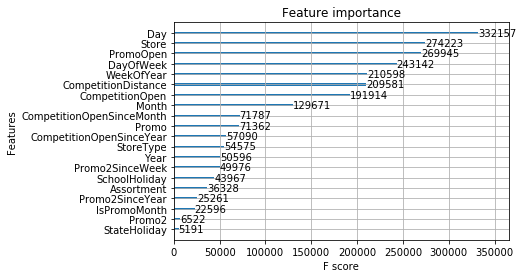

In [64]:
xgb.plot_importance(model_opt)

可以看到，最重要特征为Day和Store，这一点说明销售的周期性以及每个店铺有自己的特点。

### 模型保存

In [65]:
model_opt.save_model('/home/kael/projects/model/v2-opt.model')

### 模型优化

统计模型在验证集上的一些相关信息，再确定优化手段。

In [67]:
valid_info = pd.DataFrame(data = ho_ytest)
valid_info['Pred'] = pred_valid_opt
valid_info = pd.merge(ho_xtest,valid_info, left_index= True, right_index=True)
valid_info['Ratio'] = valid_info.Pred/valid_info.Sales
valid_info['Error'] = abs(valid_info.Ratio-1)
valid_info['RelError'] = (valid_info.Ratio-1)
valid_info['Weight'] = valid_info.Sales/valid_info.Pred
valid_info.head()[['Sales','Pred','Ratio','Error','RelError','Weight']]

,Sales,Pred,Ratio,Error,RelError,Weight
0,8.568646,8.569656,1.000118,0.000118,0.000118,0.999882
1,8.521384,8.540375,1.002229,0.002229,0.002229,0.997776
2,8.472823,8.459084,0.998378,0.001622,-0.001622,1.001624
3,8.519590,8.450873,0.991934,0.008066,-0.008066,1.008131
4,8.716536,8.534084,0.979068,0.020932,-0.020932,1.021379


看下三个店铺的真实与预测情况

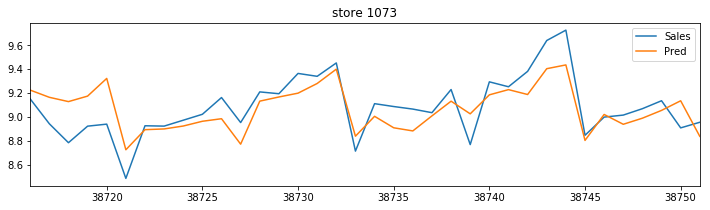

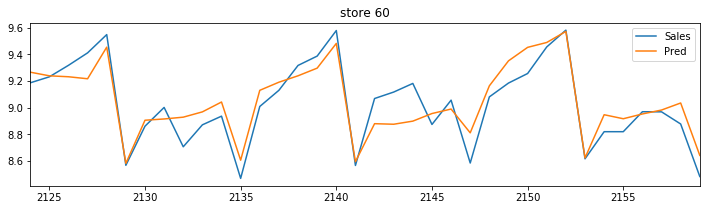

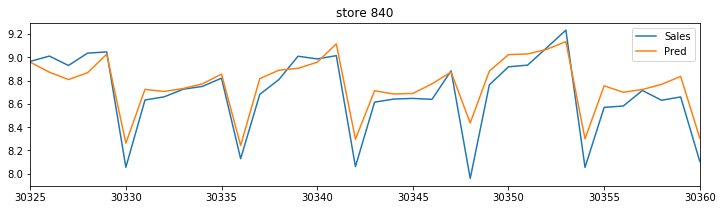

In [129]:
import random
stores = [random.choice(range(1,1116,1)) for i in range(3)]

for s in stores:
    store = pd.DataFrame(valid_info[valid_info['Store']==s],columns = ['Sales','Pred'])
    store.plot(title = 'store {}'.format(s),figsize=(12,3))

可以看到，预测值与实际值之间的差别，再来看看整体偏差。

In [69]:
print '相对偏差：'+str(valid_info.RelError.mean())

相对偏差：0.00218784928187


从相对偏差平均值可以看出我们的预测整体上是偏高，那么这种整体上的偏差就满足使用校正系数的条件。

接下来我们在看看每个店铺的相对偏差平均值，后续我们可能会针对每个店铺做修正。

每个店铺的相对偏差：


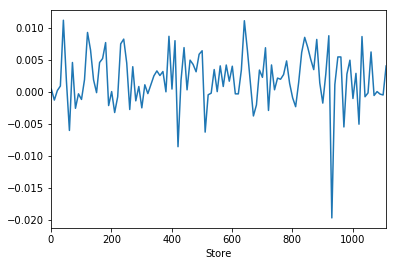

In [75]:
print '每个店铺的相对偏差：'
valid_info.groupby(['Store']).RelError.mean()[range(1,1116,10)].plot()

可以看到，各个店铺之间还是存在很大差异的，由于数据中包含有Store字段，那么我们后续干脆针对每个店铺给出校正系数来针对性的优化。

#### 校正系数：校正整体偏差

In [76]:
def get_fix_actor(pred_valid, y_valid):
    results = {}
    for actor in [0.950+i/1000. for i in range(100)]:
        results[actor]=rmspe(np.expm1(y_valid), np.expm1(pred_valid*actor))
    return results, sorted(results.items(),key = lambda x:x[1],reverse = True)[-1]

校正前：0.126374017355
校正后：
(0.996, 0.12035940620005151)


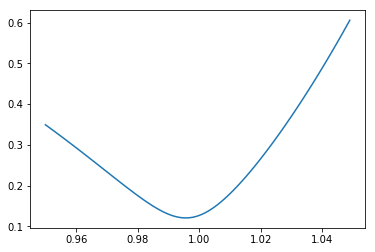

In [78]:
print '校正前：'+str(rmspe_opt)
print '校正后：'
results, actor_score = get_fix_actor(pred_valid_opt, ho_ytest)
print actor_score
items = results.items()
items.sort()
plt.plot([k for k,v in items], [v for k,v in items])
actor = actor_score[0]

In [82]:
valid_info['Actor'] = [actor]*len(valid_info)

恩恩，效果还不错，下降了0.006左右，最佳校正系数为0.996，看看加上校正系数后的数据与校正前、真实数据对比情况：

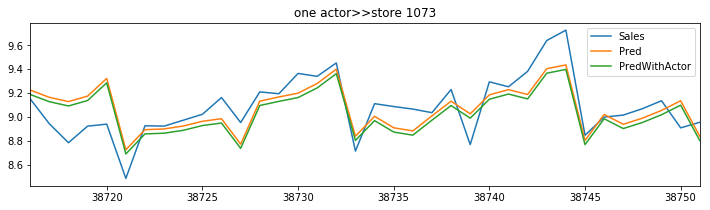

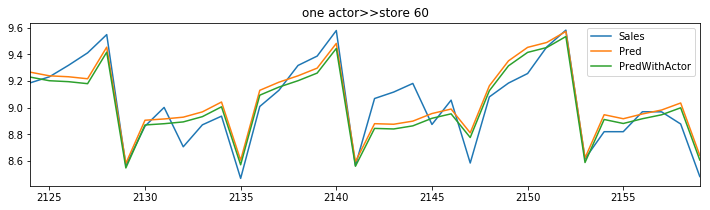

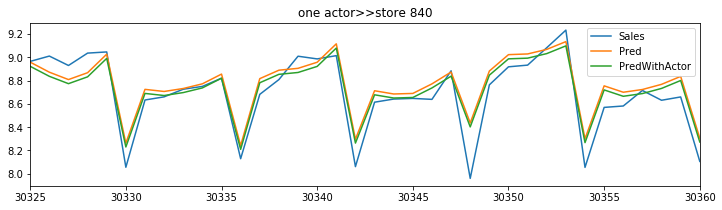

In [130]:
valid_info['PredWithActor'] = valid_info.Pred*valid_info.Actor
for s in stores:
    store = pd.DataFrame(valid_info[valid_info['Store']==s],columns = ['Sales','Pred', 'PredWithActor'])
    store.plot(title = 'one actor>>store {}'.format(s),figsize=(12,3))

可以看到，相比较于红色的未经校正的点，绿色的校正后的点明显整体上更接近于实际数据。

但是之前的校正系数是针对所有店铺统一的，那么如果分开针对每个商铺单独计算一个校正系数呢，理论上每个店铺之间还是存在很大差别的，因此针对每个店铺设置明显更加合理。

#### 针对每个店铺设置校正系数

In [97]:
store_actor = pd.DataFrame({'Store':valid_info.Store.unique(),'StoreActor':pd.Series([0]*len(valid_info.Store.unique()))})

for i in range(store_actor.Store.min(),store_actor.Store.max()+1,1):
    idx = valid_info.Store==i
    results, actor_score = get_fix_actor(pred_valid_opt[idx], ho_ytest[idx])
    store_actor.StoreActor.iloc[i-1] = actor_score[0]

store_actor.head().append(store_actor.tail())

,Store,StoreActor
0,1,0.999
1,2,1.001
2,3,0.997
3,4,1.004
4,5,0.992
1110,1111,0.993
1111,1112,0.983
1112,1113,0.998
1113,1114,1.005
1114,1115,0.992


In [98]:
valid_info = pd.merge(valid_info, store_actor, on='Store')
valid_info.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,CompetitionOpen,Sales,Pred,Ratio,Error,RelError,Weight,PredWithActor,Actor,StoreActor
0,1,4,1,0,1,3,1,1270.0,9.0,2008.0,...,82.0,8.568646,8.569656,1.000118,0.000118,0.000118,0.999882,8.535378,0.996,0.999
1,1,3,1,0,1,3,1,1270.0,9.0,2008.0,...,82.0,8.521384,8.540375,1.002229,0.002229,0.002229,0.997776,8.506213,0.996,0.999
2,1,2,1,0,1,3,1,1270.0,9.0,2008.0,...,82.0,8.472823,8.459084,0.998378,0.001622,-0.001622,1.001624,8.425247,0.996,0.999
3,1,1,1,0,1,3,1,1270.0,9.0,2008.0,...,82.0,8.519590,8.450873,0.991934,0.008066,-0.008066,1.008131,8.417070,0.996,0.999
4,1,0,1,0,1,3,1,1270.0,9.0,2008.0,...,82.0,8.716536,8.534084,0.979068,0.020932,-0.020932,1.021379,8.499948,0.996,0.999


##### 看下针对Store进行校正后的效果

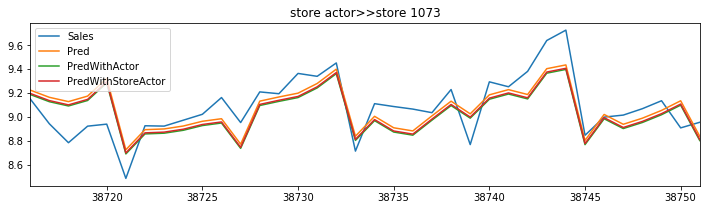

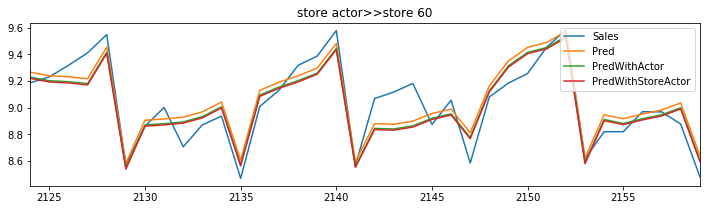

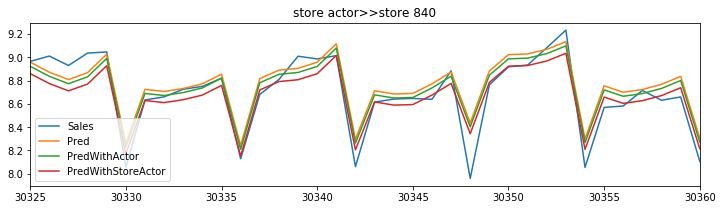

In [131]:
valid_info['PredWithStoreActor'] = valid_info.Pred*valid_info.StoreActor
for s in stores:
    store = pd.DataFrame(valid_info[valid_info['Store']==s],columns = ['Sales','Pred','PredWithActor','PredWithStoreActor'])
    store.plot(title = 'store actor>>store {}'.format(s),figsize=(12,3))

比较明显的看到，针对Store进行的校正更加贴近实际值。

#### rmspe值对比

In [111]:
print '基础模型：'+str(rmspe(np.expm1(ho_ytest), list(np.expm1(valid_info.Pred))))
print '基础模型+统一校正：'+str(rmspe(np.expm1(ho_ytest), list(np.expm1(valid_info.PredWithActor))))
print '基础模型+分别校正：'+str(rmspe(np.expm1(ho_ytest), list(np.expm1(valid_info.PredWithStoreActor))))

基础模型：0.126374017355
基础模型+统一校正：0.120359408942
基础模型+分别校正：0.11099882652


可以看到，校正系数对模型的提升还是很明显的，最终从0.126提升到了0.110。

#### 增量训练验证集数据到模型中

全数据训练的问题在于没有验证集数据用于性能验证，因此num_boost_round不好确定。

In [127]:
all_x = pd.concat([ho_xtrain, ho_xtest])
all_y = pd.concat([ho_ytrain, ho_ytest])
all_matrix = xgb.DMatrix(all_x, all_y)
watchlist_all = [(all_matrix, 'all'), (valid_matrix, 'valid')]
print 'XGBoost Model Train Start....'
start_time = time.time()
model_opt_alldate = xgb.train(params_opt, all_matrix, 2899, evals=watchlist_all, 
                  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
print 'XGBoost Model Train End, Time: {:4f} s....'.format(time.time()-start_time)

XGBoost Model Train Start....
[0]	all-rmse:8.0211	valid-rmse:8.02762	all-rmspe:0.999809	valid-rmspe:0.999811
Multiple eval metrics have been passed: 'valid-rmspe' will be used for early stopping.

Will train until valid-rmspe hasn't improved in 100 rounds.
[1]	all-rmse:7.78093	valid-rmse:7.7878	all-rmspe:0.999711	valid-rmspe:0.999714
[2]	all-rmse:7.54806	valid-rmse:7.55483	all-rmspe:0.99959	valid-rmspe:0.999595
[3]	all-rmse:7.32211	valid-rmse:7.3292	all-rmspe:0.999444	valid-rmspe:0.99945
[4]	all-rmse:7.10298	valid-rmse:7.1094	all-rmspe:0.999267	valid-rmspe:0.999275
[5]	all-rmse:6.89041	valid-rmse:6.89734	all-rmspe:0.999054	valid-rmspe:0.999065
[6]	all-rmse:6.68419	valid-rmse:6.69127	all-rmspe:0.9988	valid-rmspe:0.998814
[7]	all-rmse:6.4842	valid-rmse:6.49127	all-rmspe:0.998498	valid-rmspe:0.998516
[8]	all-rmse:6.2902	valid-rmse:6.29743	all-rmspe:0.998143	valid-rmspe:0.998165
[9]	all-rmse:6.10202	valid-rmse:6.10908	all-rmspe:0.997727	valid-rmspe:0.997754
[10]	all-rmse:5.91949	valid-rmse

[99]	all-rmse:0.468013	valid-rmse:0.468508	all-rmspe:0.367351	valid-rmspe:0.354893
[100]	all-rmse:0.457673	valid-rmse:0.458048	all-rmspe:0.361725	valid-rmspe:0.348645
[101]	all-rmse:0.44785	valid-rmse:0.447973	all-rmspe:0.356408	valid-rmspe:0.342617
[102]	all-rmse:0.438217	valid-rmse:0.43828	all-rmspe:0.351219	valid-rmspe:0.336794
[103]	all-rmse:0.428992	valid-rmse:0.428999	all-rmspe:0.346246	valid-rmspe:0.33121
[104]	all-rmse:0.420424	valid-rmse:0.420365	all-rmspe:0.341653	valid-rmspe:0.32597
[105]	all-rmse:0.412075	valid-rmse:0.411959	all-rmspe:0.337173	valid-rmspe:0.320886
[106]	all-rmse:0.404108	valid-rmse:0.403916	all-rmspe:0.332964	valid-rmspe:0.316009
[107]	all-rmse:0.396354	valid-rmse:0.396241	all-rmspe:0.328802	valid-rmspe:0.31137
[108]	all-rmse:0.388811	valid-rmse:0.38869	all-rmspe:0.324659	valid-rmspe:0.306792
[109]	all-rmse:0.381531	valid-rmse:0.381335	all-rmspe:0.320864	valid-rmspe:0.302356
[110]	all-rmse:0.374507	valid-rmse:0.374261	all-rmspe:0.317202	valid-rmspe:0.298079

[197]	all-rmse:0.196159	valid-rmse:0.194515	all-rmspe:0.236511	valid-rmspe:0.199765
[198]	all-rmse:0.195729	valid-rmse:0.194078	all-rmspe:0.236277	valid-rmspe:0.199522
[199]	all-rmse:0.19473	valid-rmse:0.193116	all-rmspe:0.235564	valid-rmspe:0.198768
[200]	all-rmse:0.194349	valid-rmse:0.192021	all-rmspe:0.235412	valid-rmspe:0.197835
[201]	all-rmse:0.193696	valid-rmse:0.191394	all-rmspe:0.234975	valid-rmspe:0.197332
[202]	all-rmse:0.193361	valid-rmse:0.19118	all-rmspe:0.234821	valid-rmspe:0.197265
[203]	all-rmse:0.19298	valid-rmse:0.190791	all-rmspe:0.233147	valid-rmspe:0.197034
[204]	all-rmse:0.192897	valid-rmse:0.190694	all-rmspe:0.233278	valid-rmspe:0.197086
[205]	all-rmse:0.192552	valid-rmse:0.19032	all-rmspe:0.233077	valid-rmspe:0.196835
[206]	all-rmse:0.192199	valid-rmse:0.190026	all-rmspe:0.232913	valid-rmspe:0.19665
[207]	all-rmse:0.191859	valid-rmse:0.189454	all-rmspe:0.232738	valid-rmspe:0.19618
[208]	all-rmse:0.191311	valid-rmse:0.188978	all-rmspe:0.232365	valid-rmspe:0.19579

[296]	all-rmse:0.154314	valid-rmse:0.15116	all-rmspe:0.196912	valid-rmspe:0.159138
[297]	all-rmse:0.153833	valid-rmse:0.150689	all-rmspe:0.196495	valid-rmspe:0.158627
[298]	all-rmse:0.153245	valid-rmse:0.150053	all-rmspe:0.195978	valid-rmspe:0.157933
[299]	all-rmse:0.152843	valid-rmse:0.149694	all-rmspe:0.195639	valid-rmspe:0.157569
[300]	all-rmse:0.152659	valid-rmse:0.149548	all-rmspe:0.195441	valid-rmspe:0.157427
[301]	all-rmse:0.15251	valid-rmse:0.149388	all-rmspe:0.19526	valid-rmspe:0.15722
[302]	all-rmse:0.152248	valid-rmse:0.149115	all-rmspe:0.194463	valid-rmspe:0.156958
[303]	all-rmse:0.15208	valid-rmse:0.148942	all-rmspe:0.194313	valid-rmspe:0.156777
[304]	all-rmse:0.151929	valid-rmse:0.148793	all-rmspe:0.194162	valid-rmspe:0.156623
[305]	all-rmse:0.151549	valid-rmse:0.148468	all-rmspe:0.193841	valid-rmspe:0.156285
[306]	all-rmse:0.151437	valid-rmse:0.148388	all-rmspe:0.193727	valid-rmspe:0.156181
[307]	all-rmse:0.151383	valid-rmse:0.148336	all-rmspe:0.192989	valid-rmspe:0.1561

[394]	all-rmse:0.133553	valid-rmse:0.130186	all-rmspe:0.166879	valid-rmspe:0.136758
[395]	all-rmse:0.133422	valid-rmse:0.130062	all-rmspe:0.166749	valid-rmspe:0.136622
[396]	all-rmse:0.133277	valid-rmse:0.129945	all-rmspe:0.166624	valid-rmspe:0.136494
[397]	all-rmse:0.13315	valid-rmse:0.129776	all-rmspe:0.166483	valid-rmspe:0.136294
[398]	all-rmse:0.132947	valid-rmse:0.129549	all-rmspe:0.166248	valid-rmspe:0.136068
[399]	all-rmse:0.132853	valid-rmse:0.129463	all-rmspe:0.166142	valid-rmspe:0.135981
[400]	all-rmse:0.132767	valid-rmse:0.129392	all-rmspe:0.16609	valid-rmspe:0.135908
[401]	all-rmse:0.132534	valid-rmse:0.129185	all-rmspe:0.165881	valid-rmspe:0.1357
[402]	all-rmse:0.132435	valid-rmse:0.129066	all-rmspe:0.165772	valid-rmspe:0.135582
[403]	all-rmse:0.132373	valid-rmse:0.128999	all-rmspe:0.16572	valid-rmspe:0.135513
[404]	all-rmse:0.132081	valid-rmse:0.128701	all-rmspe:0.165459	valid-rmspe:0.135194
[405]	all-rmse:0.13198	valid-rmse:0.128604	all-rmspe:0.165313	valid-rmspe:0.13509

[493]	all-rmse:0.120992	valid-rmse:0.11732	all-rmspe:0.149531	valid-rmspe:0.123158
[494]	all-rmse:0.120868	valid-rmse:0.117206	all-rmspe:0.149421	valid-rmspe:0.123039
[495]	all-rmse:0.120622	valid-rmse:0.116971	all-rmspe:0.149195	valid-rmspe:0.122793
[496]	all-rmse:0.12054	valid-rmse:0.116891	all-rmspe:0.149095	valid-rmspe:0.122705
[497]	all-rmse:0.120465	valid-rmse:0.116815	all-rmspe:0.149011	valid-rmspe:0.122623
[498]	all-rmse:0.120355	valid-rmse:0.116711	all-rmspe:0.148904	valid-rmspe:0.122505
[499]	all-rmse:0.120196	valid-rmse:0.116563	all-rmspe:0.148759	valid-rmspe:0.122355
[500]	all-rmse:0.119854	valid-rmse:0.116237	all-rmspe:0.148441	valid-rmspe:0.121996
[501]	all-rmse:0.11976	valid-rmse:0.11612	all-rmspe:0.148355	valid-rmspe:0.121801
[502]	all-rmse:0.119614	valid-rmse:0.115977	all-rmspe:0.14822	valid-rmspe:0.121681
[503]	all-rmse:0.119458	valid-rmse:0.115816	all-rmspe:0.148077	valid-rmspe:0.121536
[504]	all-rmse:0.119156	valid-rmse:0.115536	all-rmspe:0.147795	valid-rmspe:0.1212

[592]	all-rmse:0.110764	valid-rmse:0.106212	all-rmspe:0.137083	valid-rmspe:0.110696
[593]	all-rmse:0.110717	valid-rmse:0.10617	all-rmspe:0.13701	valid-rmspe:0.110648
[594]	all-rmse:0.110641	valid-rmse:0.106092	all-rmspe:0.136942	valid-rmspe:0.110559
[595]	all-rmse:0.110596	valid-rmse:0.106043	all-rmspe:0.136911	valid-rmspe:0.110508
[596]	all-rmse:0.110512	valid-rmse:0.105958	all-rmspe:0.136837	valid-rmspe:0.110418
[597]	all-rmse:0.110407	valid-rmse:0.105859	all-rmspe:0.136723	valid-rmspe:0.110294
[598]	all-rmse:0.110274	valid-rmse:0.105734	all-rmspe:0.13655	valid-rmspe:0.110157
[599]	all-rmse:0.110167	valid-rmse:0.105632	all-rmspe:0.136441	valid-rmspe:0.110043
[600]	all-rmse:0.110062	valid-rmse:0.105513	all-rmspe:0.136322	valid-rmspe:0.109912
[601]	all-rmse:0.110015	valid-rmse:0.105461	all-rmspe:0.136336	valid-rmspe:0.109857
[602]	all-rmse:0.109947	valid-rmse:0.105369	all-rmspe:0.136277	valid-rmspe:0.109762
[603]	all-rmse:0.109885	valid-rmse:0.105321	all-rmspe:0.136188	valid-rmspe:0.10

[690]	all-rmse:0.103903	valid-rmse:0.098968	all-rmspe:0.129047	valid-rmspe:0.102802
[691]	all-rmse:0.103872	valid-rmse:0.09894	all-rmspe:0.129012	valid-rmspe:0.102771
[692]	all-rmse:0.103808	valid-rmse:0.098889	all-rmspe:0.128139	valid-rmspe:0.102721
[693]	all-rmse:0.103781	valid-rmse:0.098787	all-rmspe:0.128107	valid-rmspe:0.102601
[694]	all-rmse:0.103758	valid-rmse:0.098767	all-rmspe:0.128085	valid-rmspe:0.102579
[695]	all-rmse:0.103696	valid-rmse:0.098714	all-rmspe:0.12803	valid-rmspe:0.102524
[696]	all-rmse:0.10365	valid-rmse:0.098682	all-rmspe:0.127974	valid-rmspe:0.102488
[697]	all-rmse:0.103578	valid-rmse:0.09861	all-rmspe:0.127884	valid-rmspe:0.102406
[698]	all-rmse:0.103516	valid-rmse:0.098548	all-rmspe:0.1275	valid-rmspe:0.10234
[699]	all-rmse:0.103421	valid-rmse:0.098457	all-rmspe:0.127417	valid-rmspe:0.102245
[700]	all-rmse:0.103397	valid-rmse:0.098355	all-rmspe:0.127393	valid-rmspe:0.102143
[701]	all-rmse:0.10332	valid-rmse:0.098252	all-rmspe:0.127325	valid-rmspe:0.102042


[788]	all-rmse:0.099178	valid-rmse:0.09384	all-rmspe:0.121258	valid-rmspe:0.097139
[789]	all-rmse:0.099152	valid-rmse:0.093826	all-rmspe:0.121241	valid-rmspe:0.097125
[790]	all-rmse:0.099111	valid-rmse:0.093795	all-rmspe:0.121196	valid-rmspe:0.097091
[791]	all-rmse:0.099058	valid-rmse:0.093761	all-rmspe:0.121063	valid-rmspe:0.097053
[792]	all-rmse:0.099011	valid-rmse:0.093721	all-rmspe:0.121017	valid-rmspe:0.097012
[793]	all-rmse:0.098923	valid-rmse:0.093631	all-rmspe:0.120934	valid-rmspe:0.096906
[794]	all-rmse:0.09889	valid-rmse:0.093601	all-rmspe:0.120279	valid-rmspe:0.096875
[795]	all-rmse:0.098829	valid-rmse:0.093558	all-rmspe:0.120182	valid-rmspe:0.096826
[796]	all-rmse:0.098805	valid-rmse:0.093513	all-rmspe:0.12016	valid-rmspe:0.096777
[797]	all-rmse:0.098756	valid-rmse:0.093458	all-rmspe:0.120118	valid-rmspe:0.096719
[798]	all-rmse:0.098704	valid-rmse:0.093437	all-rmspe:0.120062	valid-rmspe:0.096695
[799]	all-rmse:0.098692	valid-rmse:0.093399	all-rmspe:0.120051	valid-rmspe:0.09

[886]	all-rmse:0.095492	valid-rmse:0.090081	all-rmspe:0.11588	valid-rmspe:0.092981
[887]	all-rmse:0.095445	valid-rmse:0.090041	all-rmspe:0.115859	valid-rmspe:0.092941
[888]	all-rmse:0.095418	valid-rmse:0.090025	all-rmspe:0.115828	valid-rmspe:0.092928
[889]	all-rmse:0.095401	valid-rmse:0.090009	all-rmspe:0.115808	valid-rmspe:0.092913
[890]	all-rmse:0.095299	valid-rmse:0.089908	all-rmspe:0.11571	valid-rmspe:0.092801
[891]	all-rmse:0.095257	valid-rmse:0.089856	all-rmspe:0.115638	valid-rmspe:0.092747
[892]	all-rmse:0.095218	valid-rmse:0.089816	all-rmspe:0.115601	valid-rmspe:0.092704
[893]	all-rmse:0.095145	valid-rmse:0.089756	all-rmspe:0.115521	valid-rmspe:0.092637
[894]	all-rmse:0.095127	valid-rmse:0.089744	all-rmspe:0.115504	valid-rmspe:0.092624
[895]	all-rmse:0.095087	valid-rmse:0.089699	all-rmspe:0.115464	valid-rmspe:0.09258
[896]	all-rmse:0.095062	valid-rmse:0.089662	all-rmspe:0.11544	valid-rmspe:0.092536
[897]	all-rmse:0.09504	valid-rmse:0.089638	all-rmspe:0.115418	valid-rmspe:0.0925

[985]	all-rmse:0.091857	valid-rmse:0.086141	all-rmspe:0.110989	valid-rmspe:0.088788
[986]	all-rmse:0.091829	valid-rmse:0.086113	all-rmspe:0.110958	valid-rmspe:0.088758
[987]	all-rmse:0.091786	valid-rmse:0.086074	all-rmspe:0.110916	valid-rmspe:0.088715
[988]	all-rmse:0.091745	valid-rmse:0.086062	all-rmspe:0.110833	valid-rmspe:0.088699
[989]	all-rmse:0.091726	valid-rmse:0.086026	all-rmspe:0.11081	valid-rmspe:0.088661
[990]	all-rmse:0.091711	valid-rmse:0.086015	all-rmspe:0.11057	valid-rmspe:0.08865
[991]	all-rmse:0.091675	valid-rmse:0.085987	all-rmspe:0.110532	valid-rmspe:0.08862
[992]	all-rmse:0.091646	valid-rmse:0.08596	all-rmspe:0.110499	valid-rmspe:0.088591
[993]	all-rmse:0.091625	valid-rmse:0.085954	all-rmspe:0.110349	valid-rmspe:0.088584
[994]	all-rmse:0.091589	valid-rmse:0.085918	all-rmspe:0.110305	valid-rmspe:0.088552
[995]	all-rmse:0.091559	valid-rmse:0.085885	all-rmspe:0.110263	valid-rmspe:0.088516
[996]	all-rmse:0.091529	valid-rmse:0.085837	all-rmspe:0.110203	valid-rmspe:0.0884

[1083]	all-rmse:0.089308	valid-rmse:0.083309	all-rmspe:0.107263	valid-rmspe:0.085772
[1084]	all-rmse:0.089288	valid-rmse:0.083269	all-rmspe:0.107244	valid-rmspe:0.085713
[1085]	all-rmse:0.089258	valid-rmse:0.083261	all-rmspe:0.107202	valid-rmspe:0.085705
[1086]	all-rmse:0.089239	valid-rmse:0.083247	all-rmspe:0.107163	valid-rmspe:0.085688
[1087]	all-rmse:0.089215	valid-rmse:0.083218	all-rmspe:0.107025	valid-rmspe:0.08566
[1088]	all-rmse:0.089185	valid-rmse:0.083178	all-rmspe:0.107	valid-rmspe:0.085617
[1089]	all-rmse:0.089163	valid-rmse:0.08316	all-rmspe:0.106969	valid-rmspe:0.0856
[1090]	all-rmse:0.089142	valid-rmse:0.08312	all-rmspe:0.10693	valid-rmspe:0.085552
[1091]	all-rmse:0.089129	valid-rmse:0.083105	all-rmspe:0.106918	valid-rmspe:0.085533
[1092]	all-rmse:0.089079	valid-rmse:0.083049	all-rmspe:0.106869	valid-rmspe:0.085473
[1093]	all-rmse:0.089046	valid-rmse:0.082986	all-rmspe:0.106828	valid-rmspe:0.085405
[1094]	all-rmse:0.089014	valid-rmse:0.082951	all-rmspe:0.106799	valid-rmsp

[1180]	all-rmse:0.08722	valid-rmse:0.080819	all-rmspe:0.104583	valid-rmspe:0.083026
[1181]	all-rmse:0.087214	valid-rmse:0.080814	all-rmspe:0.104557	valid-rmspe:0.083021
[1182]	all-rmse:0.087208	valid-rmse:0.080808	all-rmspe:0.10455	valid-rmspe:0.083015
[1183]	all-rmse:0.087188	valid-rmse:0.080793	all-rmspe:0.104531	valid-rmspe:0.083002
[1184]	all-rmse:0.087169	valid-rmse:0.080786	all-rmspe:0.104512	valid-rmspe:0.082993
[1185]	all-rmse:0.087155	valid-rmse:0.080771	all-rmspe:0.104498	valid-rmspe:0.082978
[1186]	all-rmse:0.087139	valid-rmse:0.080758	all-rmspe:0.104478	valid-rmspe:0.082965
[1187]	all-rmse:0.087125	valid-rmse:0.08074	all-rmspe:0.104465	valid-rmspe:0.082949
[1188]	all-rmse:0.087114	valid-rmse:0.080734	all-rmspe:0.104454	valid-rmspe:0.082941
[1189]	all-rmse:0.087102	valid-rmse:0.080724	all-rmspe:0.104443	valid-rmspe:0.082931
[1190]	all-rmse:0.087077	valid-rmse:0.080709	all-rmspe:0.104407	valid-rmspe:0.082918
[1191]	all-rmse:0.087056	valid-rmse:0.080705	all-rmspe:0.104369	vali

[1277]	all-rmse:0.085282	valid-rmse:0.078812	all-rmspe:0.101354	valid-rmspe:0.080886
[1278]	all-rmse:0.085269	valid-rmse:0.078808	all-rmspe:0.101331	valid-rmspe:0.080882
[1279]	all-rmse:0.085254	valid-rmse:0.078793	all-rmspe:0.101317	valid-rmspe:0.080866
[1280]	all-rmse:0.085242	valid-rmse:0.078771	all-rmspe:0.101305	valid-rmspe:0.080843
[1281]	all-rmse:0.085231	valid-rmse:0.07874	all-rmspe:0.101295	valid-rmspe:0.080792
[1282]	all-rmse:0.085216	valid-rmse:0.078726	all-rmspe:0.101282	valid-rmspe:0.080777
[1283]	all-rmse:0.085193	valid-rmse:0.078705	all-rmspe:0.101253	valid-rmspe:0.080756
[1284]	all-rmse:0.085173	valid-rmse:0.078683	all-rmspe:0.101234	valid-rmspe:0.08073
[1285]	all-rmse:0.085159	valid-rmse:0.078677	all-rmspe:0.101217	valid-rmspe:0.080723
[1286]	all-rmse:0.085144	valid-rmse:0.07866	all-rmspe:0.101203	valid-rmspe:0.080705
[1287]	all-rmse:0.085131	valid-rmse:0.078642	all-rmspe:0.101188	valid-rmspe:0.080683
[1288]	all-rmse:0.085099	valid-rmse:0.078591	all-rmspe:0.101147	vali

[1374]	all-rmse:0.083625	valid-rmse:0.076901	all-rmspe:0.098742	valid-rmspe:0.078773
[1375]	all-rmse:0.083611	valid-rmse:0.076897	all-rmspe:0.098729	valid-rmspe:0.078769
[1376]	all-rmse:0.083599	valid-rmse:0.076882	all-rmspe:0.098717	valid-rmspe:0.078755
[1377]	all-rmse:0.083571	valid-rmse:0.076859	all-rmspe:0.098681	valid-rmspe:0.078731
[1378]	all-rmse:0.08355	valid-rmse:0.076846	all-rmspe:0.098657	valid-rmspe:0.078718
[1379]	all-rmse:0.08354	valid-rmse:0.076818	all-rmspe:0.098646	valid-rmspe:0.07869
[1380]	all-rmse:0.083519	valid-rmse:0.0768	all-rmspe:0.098611	valid-rmspe:0.078673
[1381]	all-rmse:0.08351	valid-rmse:0.076787	all-rmspe:0.098603	valid-rmspe:0.078657
[1382]	all-rmse:0.083454	valid-rmse:0.076733	all-rmspe:0.09855	valid-rmspe:0.078601
[1383]	all-rmse:0.083433	valid-rmse:0.076716	all-rmspe:0.098526	valid-rmspe:0.078584
[1384]	all-rmse:0.083413	valid-rmse:0.0767	all-rmspe:0.098253	valid-rmspe:0.078568
[1385]	all-rmse:0.083396	valid-rmse:0.076689	all-rmspe:0.098236	valid-rmsp

[1471]	all-rmse:0.081983	valid-rmse:0.075128	all-rmspe:0.095896	valid-rmspe:0.076894
[1472]	all-rmse:0.081968	valid-rmse:0.075112	all-rmspe:0.09588	valid-rmspe:0.076875
[1473]	all-rmse:0.081955	valid-rmse:0.075088	all-rmspe:0.095866	valid-rmspe:0.076847
[1474]	all-rmse:0.081944	valid-rmse:0.07508	all-rmspe:0.095856	valid-rmspe:0.07684
[1475]	all-rmse:0.081925	valid-rmse:0.075049	all-rmspe:0.09581	valid-rmspe:0.076809
[1476]	all-rmse:0.081917	valid-rmse:0.075042	all-rmspe:0.095801	valid-rmspe:0.076803
[1477]	all-rmse:0.081902	valid-rmse:0.075032	all-rmspe:0.095788	valid-rmspe:0.076792
[1478]	all-rmse:0.081881	valid-rmse:0.07501	all-rmspe:0.095717	valid-rmspe:0.076769
[1479]	all-rmse:0.08187	valid-rmse:0.074998	all-rmspe:0.095707	valid-rmspe:0.076757
[1480]	all-rmse:0.081851	valid-rmse:0.074982	all-rmspe:0.095682	valid-rmspe:0.076739
[1481]	all-rmse:0.081837	valid-rmse:0.074967	all-rmspe:0.095646	valid-rmspe:0.076725
[1482]	all-rmse:0.081825	valid-rmse:0.074951	all-rmspe:0.095635	valid-r

[1568]	all-rmse:0.080578	valid-rmse:0.073765	all-rmspe:0.092804	valid-rmspe:0.075426
[1569]	all-rmse:0.080568	valid-rmse:0.073761	all-rmspe:0.092792	valid-rmspe:0.075422
[1570]	all-rmse:0.080552	valid-rmse:0.073739	all-rmspe:0.092777	valid-rmspe:0.0754
[1571]	all-rmse:0.080545	valid-rmse:0.073731	all-rmspe:0.092771	valid-rmspe:0.075392
[1572]	all-rmse:0.080532	valid-rmse:0.073702	all-rmspe:0.092755	valid-rmspe:0.075365
[1573]	all-rmse:0.080514	valid-rmse:0.07368	all-rmspe:0.092735	valid-rmspe:0.075339
[1574]	all-rmse:0.080497	valid-rmse:0.073669	all-rmspe:0.092699	valid-rmspe:0.075327
[1575]	all-rmse:0.080476	valid-rmse:0.07365	all-rmspe:0.09268	valid-rmspe:0.075307
[1576]	all-rmse:0.080456	valid-rmse:0.073608	all-rmspe:0.092654	valid-rmspe:0.075264
[1577]	all-rmse:0.080441	valid-rmse:0.073596	all-rmspe:0.092638	valid-rmspe:0.07525
[1578]	all-rmse:0.08043	valid-rmse:0.073588	all-rmspe:0.092629	valid-rmspe:0.075243
[1579]	all-rmse:0.080409	valid-rmse:0.073585	all-rmspe:0.09259	valid-rms

[1666]	all-rmse:0.07923	valid-rmse:0.072342	all-rmspe:0.090455	valid-rmspe:0.073922
[1667]	all-rmse:0.079213	valid-rmse:0.072316	all-rmspe:0.090419	valid-rmspe:0.073895
[1668]	all-rmse:0.079206	valid-rmse:0.072307	all-rmspe:0.090411	valid-rmspe:0.073886
[1669]	all-rmse:0.07919	valid-rmse:0.072294	all-rmspe:0.090393	valid-rmspe:0.073872
[1670]	all-rmse:0.079178	valid-rmse:0.072282	all-rmspe:0.09038	valid-rmspe:0.073859
[1671]	all-rmse:0.079168	valid-rmse:0.072274	all-rmspe:0.090363	valid-rmspe:0.073851
[1672]	all-rmse:0.079151	valid-rmse:0.072252	all-rmspe:0.090347	valid-rmspe:0.073828
[1673]	all-rmse:0.079141	valid-rmse:0.072242	all-rmspe:0.090338	valid-rmspe:0.073818
[1674]	all-rmse:0.079128	valid-rmse:0.072225	all-rmspe:0.090322	valid-rmspe:0.0738
[1675]	all-rmse:0.079116	valid-rmse:0.072207	all-rmspe:0.090311	valid-rmspe:0.073783
[1676]	all-rmse:0.079095	valid-rmse:0.072189	all-rmspe:0.090288	valid-rmspe:0.073766
[1677]	all-rmse:0.079082	valid-rmse:0.072186	all-rmspe:0.090273	valid-

[1763]	all-rmse:0.077968	valid-rmse:0.071072	all-rmspe:0.087879	valid-rmspe:0.072579
[1764]	all-rmse:0.077956	valid-rmse:0.071061	all-rmspe:0.087863	valid-rmspe:0.072569
[1765]	all-rmse:0.077946	valid-rmse:0.071052	all-rmspe:0.087854	valid-rmspe:0.07256
[1766]	all-rmse:0.077936	valid-rmse:0.071042	all-rmspe:0.08784	valid-rmspe:0.07255
[1767]	all-rmse:0.077925	valid-rmse:0.071	all-rmspe:0.087826	valid-rmspe:0.072506
[1768]	all-rmse:0.077919	valid-rmse:0.070998	all-rmspe:0.087816	valid-rmspe:0.072504
[1769]	all-rmse:0.077905	valid-rmse:0.070978	all-rmspe:0.087793	valid-rmspe:0.072483
[1770]	all-rmse:0.07789	valid-rmse:0.070969	all-rmspe:0.087774	valid-rmspe:0.072474
[1771]	all-rmse:0.077881	valid-rmse:0.070942	all-rmspe:0.087764	valid-rmspe:0.072447
[1772]	all-rmse:0.077876	valid-rmse:0.070911	all-rmspe:0.087758	valid-rmspe:0.072413
[1773]	all-rmse:0.077865	valid-rmse:0.070901	all-rmspe:0.087746	valid-rmspe:0.072403
[1774]	all-rmse:0.077858	valid-rmse:0.070892	all-rmspe:0.087739	valid-rm

[1860]	all-rmse:0.076925	valid-rmse:0.06973	all-rmspe:0.086317	valid-rmspe:0.071131
[1861]	all-rmse:0.076919	valid-rmse:0.069724	all-rmspe:0.086297	valid-rmspe:0.071125
[1862]	all-rmse:0.07691	valid-rmse:0.069702	all-rmspe:0.086288	valid-rmspe:0.071103
[1863]	all-rmse:0.076901	valid-rmse:0.069697	all-rmspe:0.086279	valid-rmspe:0.071098
[1864]	all-rmse:0.076884	valid-rmse:0.069682	all-rmspe:0.086262	valid-rmspe:0.071083
[1865]	all-rmse:0.076865	valid-rmse:0.069652	all-rmspe:0.086211	valid-rmspe:0.071036
[1866]	all-rmse:0.076852	valid-rmse:0.069636	all-rmspe:0.086194	valid-rmspe:0.07102
[1867]	all-rmse:0.076844	valid-rmse:0.06963	all-rmspe:0.086212	valid-rmspe:0.071014
[1868]	all-rmse:0.076831	valid-rmse:0.069616	all-rmspe:0.086198	valid-rmspe:0.070999
[1869]	all-rmse:0.076819	valid-rmse:0.069603	all-rmspe:0.086183	valid-rmspe:0.070984
[1870]	all-rmse:0.076808	valid-rmse:0.069596	all-rmspe:0.086172	valid-rmspe:0.070977
[1871]	all-rmse:0.076801	valid-rmse:0.069592	all-rmspe:0.086166	valid

[1957]	all-rmse:0.075893	valid-rmse:0.068627	all-rmspe:0.08491	valid-rmspe:0.069908
[1958]	all-rmse:0.075882	valid-rmse:0.068615	all-rmspe:0.084899	valid-rmspe:0.069896
[1959]	all-rmse:0.075868	valid-rmse:0.068608	all-rmspe:0.084638	valid-rmspe:0.069888
[1960]	all-rmse:0.075863	valid-rmse:0.068604	all-rmspe:0.084633	valid-rmspe:0.069884
[1961]	all-rmse:0.075848	valid-rmse:0.068589	all-rmspe:0.084616	valid-rmspe:0.069868
[1962]	all-rmse:0.075828	valid-rmse:0.068573	all-rmspe:0.084591	valid-rmspe:0.06985
[1963]	all-rmse:0.075819	valid-rmse:0.068566	all-rmspe:0.084581	valid-rmspe:0.069844
[1964]	all-rmse:0.075812	valid-rmse:0.06856	all-rmspe:0.084574	valid-rmspe:0.069837
[1965]	all-rmse:0.075797	valid-rmse:0.068542	all-rmspe:0.084558	valid-rmspe:0.069818
[1966]	all-rmse:0.075789	valid-rmse:0.068533	all-rmspe:0.08455	valid-rmspe:0.06981
[1967]	all-rmse:0.075779	valid-rmse:0.068522	all-rmspe:0.084541	valid-rmspe:0.069799
[1968]	all-rmse:0.075765	valid-rmse:0.068512	all-rmspe:0.084518	valid-

[2054]	all-rmse:0.074931	valid-rmse:0.06762	all-rmspe:0.083453	valid-rmspe:0.068805
[2055]	all-rmse:0.074924	valid-rmse:0.067578	all-rmspe:0.083445	valid-rmspe:0.068761
[2056]	all-rmse:0.074914	valid-rmse:0.067566	all-rmspe:0.083435	valid-rmspe:0.068746
[2057]	all-rmse:0.074903	valid-rmse:0.067555	all-rmspe:0.083422	valid-rmspe:0.068735
[2058]	all-rmse:0.074893	valid-rmse:0.067547	all-rmspe:0.08341	valid-rmspe:0.068728
[2059]	all-rmse:0.074884	valid-rmse:0.067544	all-rmspe:0.083401	valid-rmspe:0.068724
[2060]	all-rmse:0.074877	valid-rmse:0.067538	all-rmspe:0.083394	valid-rmspe:0.06872
[2061]	all-rmse:0.074864	valid-rmse:0.067525	all-rmspe:0.083379	valid-rmspe:0.068705
[2062]	all-rmse:0.074853	valid-rmse:0.067515	all-rmspe:0.083366	valid-rmspe:0.068694
[2063]	all-rmse:0.074846	valid-rmse:0.0675	all-rmspe:0.083359	valid-rmspe:0.068679
[2064]	all-rmse:0.07484	valid-rmse:0.067496	all-rmspe:0.083353	valid-rmspe:0.068674
[2065]	all-rmse:0.074827	valid-rmse:0.067486	all-rmspe:0.083341	valid-r

[2151]	all-rmse:0.074039	valid-rmse:0.066624	all-rmspe:0.082151	valid-rmspe:0.067738
[2152]	all-rmse:0.074033	valid-rmse:0.066619	all-rmspe:0.082144	valid-rmspe:0.067733
[2153]	all-rmse:0.074025	valid-rmse:0.066612	all-rmspe:0.082137	valid-rmspe:0.067725
[2154]	all-rmse:0.074013	valid-rmse:0.066578	all-rmspe:0.082121	valid-rmspe:0.067687
[2155]	all-rmse:0.074006	valid-rmse:0.066572	all-rmspe:0.082113	valid-rmspe:0.067681
[2156]	all-rmse:0.073995	valid-rmse:0.066566	all-rmspe:0.082102	valid-rmspe:0.067674
[2157]	all-rmse:0.073988	valid-rmse:0.066555	all-rmspe:0.082093	valid-rmspe:0.067663
[2158]	all-rmse:0.073982	valid-rmse:0.066529	all-rmspe:0.082087	valid-rmspe:0.067637
[2159]	all-rmse:0.073976	valid-rmse:0.066524	all-rmspe:0.082081	valid-rmspe:0.067632
[2160]	all-rmse:0.073968	valid-rmse:0.066515	all-rmspe:0.082076	valid-rmspe:0.067622
[2161]	all-rmse:0.073959	valid-rmse:0.066504	all-rmspe:0.082061	valid-rmspe:0.06761
[2162]	all-rmse:0.073947	valid-rmse:0.066493	all-rmspe:0.082044	va

[2248]	all-rmse:0.073162	valid-rmse:0.065645	all-rmspe:0.080909	valid-rmspe:0.066698
[2249]	all-rmse:0.073152	valid-rmse:0.06564	all-rmspe:0.080899	valid-rmspe:0.066692
[2250]	all-rmse:0.073147	valid-rmse:0.065635	all-rmspe:0.080893	valid-rmspe:0.066688
[2251]	all-rmse:0.073133	valid-rmse:0.06562	all-rmspe:0.080877	valid-rmspe:0.066673
[2252]	all-rmse:0.073123	valid-rmse:0.065616	all-rmspe:0.080866	valid-rmspe:0.066668
[2253]	all-rmse:0.073116	valid-rmse:0.065614	all-rmspe:0.08086	valid-rmspe:0.066667
[2254]	all-rmse:0.073105	valid-rmse:0.065609	all-rmspe:0.080841	valid-rmspe:0.066663
[2255]	all-rmse:0.0731	valid-rmse:0.065606	all-rmspe:0.080835	valid-rmspe:0.06666
[2256]	all-rmse:0.07309	valid-rmse:0.065592	all-rmspe:0.080824	valid-rmspe:0.066643
[2257]	all-rmse:0.073083	valid-rmse:0.065585	all-rmspe:0.080815	valid-rmspe:0.066637
[2258]	all-rmse:0.073076	valid-rmse:0.065578	all-rmspe:0.080808	valid-rmspe:0.06663
[2259]	all-rmse:0.073068	valid-rmse:0.06557	all-rmspe:0.080797	valid-rmsp

[2345]	all-rmse:0.072339	valid-rmse:0.064825	all-rmspe:0.079768	valid-rmspe:0.065847
[2346]	all-rmse:0.072333	valid-rmse:0.064819	all-rmspe:0.079761	valid-rmspe:0.065841
[2347]	all-rmse:0.072326	valid-rmse:0.064811	all-rmspe:0.07977	valid-rmspe:0.065833
[2348]	all-rmse:0.072316	valid-rmse:0.064805	all-rmspe:0.079759	valid-rmspe:0.065827
[2349]	all-rmse:0.072306	valid-rmse:0.064783	all-rmspe:0.079744	valid-rmspe:0.065803
[2350]	all-rmse:0.072302	valid-rmse:0.064781	all-rmspe:0.07974	valid-rmspe:0.065801
[2351]	all-rmse:0.072296	valid-rmse:0.064772	all-rmspe:0.079708	valid-rmspe:0.065792
[2352]	all-rmse:0.072289	valid-rmse:0.064768	all-rmspe:0.079701	valid-rmspe:0.065788
[2353]	all-rmse:0.072284	valid-rmse:0.064735	all-rmspe:0.079697	valid-rmspe:0.065751
[2354]	all-rmse:0.07228	valid-rmse:0.06473	all-rmspe:0.079692	valid-rmspe:0.065746
[2355]	all-rmse:0.072267	valid-rmse:0.06472	all-rmspe:0.079496	valid-rmspe:0.065737
[2356]	all-rmse:0.072256	valid-rmse:0.064706	all-rmspe:0.07948	valid-r

[2442]	all-rmse:0.071548	valid-rmse:0.063901	all-rmspe:0.078577	valid-rmspe:0.064864
[2443]	all-rmse:0.071541	valid-rmse:0.063887	all-rmspe:0.078568	valid-rmspe:0.064847
[2444]	all-rmse:0.071537	valid-rmse:0.063885	all-rmspe:0.078563	valid-rmspe:0.064846
[2445]	all-rmse:0.071527	valid-rmse:0.063883	all-rmspe:0.078546	valid-rmspe:0.064845
[2446]	all-rmse:0.071522	valid-rmse:0.063879	all-rmspe:0.078539	valid-rmspe:0.06484
[2447]	all-rmse:0.071519	valid-rmse:0.063877	all-rmspe:0.078537	valid-rmspe:0.064838
[2448]	all-rmse:0.071514	valid-rmse:0.063872	all-rmspe:0.078531	valid-rmspe:0.064832
[2449]	all-rmse:0.071506	valid-rmse:0.063862	all-rmspe:0.078522	valid-rmspe:0.064823
[2450]	all-rmse:0.071501	valid-rmse:0.063861	all-rmspe:0.078513	valid-rmspe:0.064822
[2451]	all-rmse:0.071488	valid-rmse:0.063845	all-rmspe:0.078496	valid-rmspe:0.064805
[2452]	all-rmse:0.071477	valid-rmse:0.063833	all-rmspe:0.078471	valid-rmspe:0.064786
[2453]	all-rmse:0.07147	valid-rmse:0.063827	all-rmspe:0.078462	val

[2539]	all-rmse:0.07077	valid-rmse:0.063062	all-rmspe:0.077191	valid-rmspe:0.063943
[2540]	all-rmse:0.07076	valid-rmse:0.063058	all-rmspe:0.077178	valid-rmspe:0.063939
[2541]	all-rmse:0.070754	valid-rmse:0.063053	all-rmspe:0.077172	valid-rmspe:0.063934
[2542]	all-rmse:0.070747	valid-rmse:0.063044	all-rmspe:0.077162	valid-rmspe:0.063924
[2543]	all-rmse:0.07074	valid-rmse:0.063033	all-rmspe:0.077154	valid-rmspe:0.063912
[2544]	all-rmse:0.070735	valid-rmse:0.063026	all-rmspe:0.077149	valid-rmspe:0.063905
[2545]	all-rmse:0.070729	valid-rmse:0.063022	all-rmspe:0.07714	valid-rmspe:0.0639
[2546]	all-rmse:0.070726	valid-rmse:0.063019	all-rmspe:0.077136	valid-rmspe:0.063897
[2547]	all-rmse:0.070721	valid-rmse:0.063013	all-rmspe:0.077131	valid-rmspe:0.063891
[2548]	all-rmse:0.070714	valid-rmse:0.063009	all-rmspe:0.07712	valid-rmspe:0.063887
[2549]	all-rmse:0.070708	valid-rmse:0.063004	all-rmspe:0.077112	valid-rmspe:0.063882
[2550]	all-rmse:0.070699	valid-rmse:0.062976	all-rmspe:0.077096	valid-rm

[2636]	all-rmse:0.070041	valid-rmse:0.062208	all-rmspe:0.076001	valid-rmspe:0.063031
[2637]	all-rmse:0.070035	valid-rmse:0.062203	all-rmspe:0.075994	valid-rmspe:0.063026
[2638]	all-rmse:0.070025	valid-rmse:0.062195	all-rmspe:0.075979	valid-rmspe:0.063017
[2639]	all-rmse:0.070015	valid-rmse:0.062191	all-rmspe:0.075969	valid-rmspe:0.063014
[2640]	all-rmse:0.070006	valid-rmse:0.062179	all-rmspe:0.07596	valid-rmspe:0.063002
[2641]	all-rmse:0.070001	valid-rmse:0.062176	all-rmspe:0.075955	valid-rmspe:0.062998
[2642]	all-rmse:0.069997	valid-rmse:0.062166	all-rmspe:0.075951	valid-rmspe:0.062988
[2643]	all-rmse:0.069991	valid-rmse:0.062162	all-rmspe:0.075941	valid-rmspe:0.062982
[2644]	all-rmse:0.069984	valid-rmse:0.062154	all-rmspe:0.075932	valid-rmspe:0.062975
[2645]	all-rmse:0.069975	valid-rmse:0.062149	all-rmspe:0.075921	valid-rmspe:0.062969
[2646]	all-rmse:0.069961	valid-rmse:0.062135	all-rmspe:0.075905	valid-rmspe:0.062954
[2647]	all-rmse:0.06995	valid-rmse:0.062128	all-rmspe:0.075889	val

[2733]	all-rmse:0.069306	valid-rmse:0.061471	all-rmspe:0.074948	valid-rmspe:0.062259
[2734]	all-rmse:0.069299	valid-rmse:0.061465	all-rmspe:0.074942	valid-rmspe:0.062252
[2735]	all-rmse:0.069293	valid-rmse:0.061458	all-rmspe:0.074935	valid-rmspe:0.062244
[2736]	all-rmse:0.069283	valid-rmse:0.06145	all-rmspe:0.074924	valid-rmspe:0.062236
[2737]	all-rmse:0.069278	valid-rmse:0.061441	all-rmspe:0.074916	valid-rmspe:0.062227
[2738]	all-rmse:0.069271	valid-rmse:0.061433	all-rmspe:0.074909	valid-rmspe:0.062218
[2739]	all-rmse:0.069268	valid-rmse:0.061433	all-rmspe:0.074905	valid-rmspe:0.062218
[2740]	all-rmse:0.069258	valid-rmse:0.061422	all-rmspe:0.074893	valid-rmspe:0.062207
[2741]	all-rmse:0.069253	valid-rmse:0.061408	all-rmspe:0.074885	valid-rmspe:0.062192
[2742]	all-rmse:0.069249	valid-rmse:0.061406	all-rmspe:0.074881	valid-rmspe:0.062189
[2743]	all-rmse:0.069242	valid-rmse:0.061403	all-rmspe:0.074874	valid-rmspe:0.062187
[2744]	all-rmse:0.069236	valid-rmse:0.061401	all-rmspe:0.074866	va

[2830]	all-rmse:0.068634	valid-rmse:0.060765	all-rmspe:0.074092	valid-rmspe:0.061514
[2831]	all-rmse:0.068628	valid-rmse:0.06076	all-rmspe:0.074086	valid-rmspe:0.061507
[2832]	all-rmse:0.068622	valid-rmse:0.060753	all-rmspe:0.074079	valid-rmspe:0.061502
[2833]	all-rmse:0.068613	valid-rmse:0.060746	all-rmspe:0.07407	valid-rmspe:0.061495
[2834]	all-rmse:0.068608	valid-rmse:0.060742	all-rmspe:0.074044	valid-rmspe:0.06149
[2835]	all-rmse:0.068599	valid-rmse:0.060735	all-rmspe:0.074032	valid-rmspe:0.061484
[2836]	all-rmse:0.06859	valid-rmse:0.060726	all-rmspe:0.074023	valid-rmspe:0.061474
[2837]	all-rmse:0.068585	valid-rmse:0.060724	all-rmspe:0.074018	valid-rmspe:0.061472
[2838]	all-rmse:0.068574	valid-rmse:0.060717	all-rmspe:0.073995	valid-rmspe:0.061465
[2839]	all-rmse:0.068567	valid-rmse:0.060711	all-rmspe:0.073988	valid-rmspe:0.061459
[2840]	all-rmse:0.068556	valid-rmse:0.060704	all-rmspe:0.073961	valid-rmspe:0.061452
[2841]	all-rmse:0.068549	valid-rmse:0.060698	all-rmspe:0.073949	valid

## kaggle上对比

In [113]:
test_x = test_all.drop(['Id','Date','Open','PromoInterval','monthStr'],axis = 1)
test_id = test_all.Id

### 基准模型

In [114]:
pd.DataFrame({'Id':test_id, 'Sales':pd.Series([pred_base]*len(test_id))}).to_csv('submission_baseline-v2.csv', index=False)

#### kaggle反馈

![截图](image/baseline-v2.png)

### XGB模型

In [118]:
pred_test_xgb = np.expm1(model_opt.predict(xgb.DMatrix(test_x)))
pd.DataFrame({'Id':test_id, 'Sales':pred_test_xgb}).to_csv('submission_xgb-v2.csv', index=False)

#### kaggle反馈

![截图](image/xgb-v2.png)

### XGB模型&校正系数

In [123]:
pred_test_xgb_actor = np.expm1(model_opt.predict(xgb.DMatrix(test_x))*valid_info.Actor.iloc[0])
pd.DataFrame({'Id':test_id, 'Sales':pred_test_xgb_actor}).to_csv('submission_xgb_actor-v2.csv', index=False)

#### kaggle反馈

![截图](image/xgb-actor-v2.png)

### XGB模型&多校正系数

In [124]:
p = model_opt.predict(xgb.DMatrix(test_x))
for i in range(len(test_x)):
    p[i] = p[i]*valid_info[valid_info.Store==test_x.Store.iloc[i]].StoreActor.iloc[0]
pred_test_xgb_nactor = np.expm1(p)
pd.DataFrame({'Id':test_id, 'Sales':pred_test_xgb_nactor}).to_csv('submission_xgb_nactor-v2.csv', index=False)

#### kaggle反馈

![截图](image/xgb-nactor-v2.png)

### XGB模型&完整训练集

In [128]:
p2 = model_opt_alldate.predict(xgb.DMatrix(test_x))
for i in range(len(test_x)):
    p2[i] = p2[i]*valid_info[valid_info.Store==test_x.Store.iloc[i]].StoreActor.iloc[0]
pred_test_xgb_alldata = np.expm1(p2)
pd.DataFrame({'Id':test_id, 'Sales':pred_test_xgb_alldata}).to_csv('submission_xgb_alldata-v2.csv', index=False)

#### kaggle反馈

![截图](image/xgb-alldata-v2.png)

## 结论

能够看到，XGBoost模型经过参数优化、校正系数在Kaggle的得分上取得以下进展：
* private:0.11188
* public:0.11212

可以看到，优化还是提到了很大的效果的，同时使用完整训练集的点子是不错的，但是由于缺乏验证集，结果反而不如仅仅使用划分后的训练集的效果，也充分证明了验证集的重要性。